## From 
https://www.rasgoml.com/feature-engineering-tutorials/backward-stepwise-feature-selection-with-scikit-learn

In [1]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
# import category_encoders as ce

from sklearn.ensemble import GradientBoostingRegressor


In [2]:
import dtale


In [3]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
import seaborn as sns
import matplotlib as plt
import pandas as pd
from datetime import datetime
import dtale
import os
%matplotlib inline

### Predictors I should pick
1. Length of the orbit crossing the lake: orbit_leng
2. Area of the lake influence by the orbit: area_buffe
3. Lake area: Lake_area
4. Topography roughness: TRI_mdn
5. Variability of Lake surface water elevation (Option 1): APL
6. Variability of Lake surface water elevation (Option 2 flashiness index Baker 2004): rb_index
7. Variance of observations?? roughness. Standard deviation of the differences, based on https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r. I have std_diff and mean_diff. To calculate the variability it should be std_diff/abs(mean_diff) if mean diff!=0
8. Standard deviation of the observations std_obs
9. Probablility of ICE ??
10. No Samples from altimeter data
##3 Reponse variables to try

## 1. Length of the orbit crossing the lake 
## To get the total length
### - Get the lakes
### - Open sd file
### - Link lakes to sd file
### - Filter only the evaluation lakes
### - Group lakes by lake_id and orbit to sum the length (sum the projected and non projected length

In [168]:
# Function to get Karina's station data 
def get_us_ca_data(df_results, gauge_id_fd, path_to_obs, folder_sep):
    list_gauges=df_results[gauge_id_fd].unique()
    #TODO validate empty list
    df_files=pd.DataFrame()
    for folder,details in folder_sep.items():
        path=path_to_obs+folder+'/'
        sep=details['sep']
        org_col_fd=details['fields'].values()
        new_col_fd={v: k for k, v in details['fields'].items()} 
        # print(sep, new_col_fd)
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))&(f.endswith('.dat'))&(f[:-4] in list_gauges)]
         
        for f in files:
            f_name=path+f
            df_file=pd.read_csv(f_name, sep=sep)
            df_file=df_file[org_col_fd]
            df_file=df_file.rename(columns=new_col_fd)
            df_file['gauge_id']=f[:-4]
            df_files=pd.concat([df_files, df_file], axis=0)

    return df_files
def aggregage_values_by_group(df, group_by_fds, sum_dict):
    
    df = df.groupby(group_by_fds).aggregate(sum_dict)
    df.columns = ['_'.join([str(c) for c in col]).strip() for col in df.columns.values]
    if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
        df = df.to_frame(index=False)
    return df.reset_index()

def change_df_col_names(df, new_colnames):
    '''Change all the names of a dataframe by the names in new_colnames. The columns are changed in the same order of new_colnames'''
    for nn in new_colnames:
        df.rename(columns={df.columns[new_colnames.index(nn)]:nn}, inplace=True) 
    return df
 

In [169]:
# open lakes
path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'
df_sel_lakes=gpd.read_file(path_lakes)

# open orbit files for karina and SylvainDennis (this last ones are for evaluation)
path_orbits_ka= '/home/angelica/Documents/py_linux/pylocss/data/area_orbits_in_lakes/orbit_length_cross_ka.csv'
path_orbits_sd= '/home/angelica/Documents/py_linux/pylocss/data/area_orbits_in_lakes/orbit_length_cross_sd.csv'

df_orbits_ka=pd.read_csv(path_orbits_ka, sep=',')
df_orbits_sd=pd.read_csv(path_orbits_sd, sep=',')

# open resulting evaluation file 
path_results_eval='../data/results/comparison__20230331_16_54.csv'
df_results=pd.read_csv(path_results_eval, sep=',')
df_results.rename(columns={'station':'gauge_id'}, inplace=True)
# Mark the dataframe to be part of the evaluation in the paper
df_results['section']='eval'

# open TRI resulting file

path_TRI_summary_95= '/home/angelica/Documents/py_linux/pylocss/data/results/TRI_stats_95_5km_20230330_12_35.csv'
path_TRI_summary_all='/home/angelica/Documents/py_linux/pylocss/data/results/TRI_stats_all_5km_20230330_12_35.csv'

df_TRI_95=pd.read_csv(path_TRI_summary_95, sep=',')
df_TRI_all=pd.read_csv(path_TRI_summary_all, sep=',')

# open stations from Karina's work
path_results_karina='/home/angelica/Documents/py_linux/pylocss/data/karina/result_karina/results_karina_US_CA.shp'
df_results_ka=gpd.read_file(path_results_karina)
df_results_ka['section']='fact' #fact refers to using the dataset only for factor of importance

#open original data from karina
path_to_obs_ka='/home/angelica/Documents/py_linux/pylocss/data/karina/gauge_observations/'
gauge_id_fd='gaugeid'
folder_sep={'gaugedatUS':{'sep':' ','fields':{'date':'date', 'elev':'elev', 'decimal_time':'time'}},
            'gaugedatahist':{'sep':',','fields':{'date':'Date', 'elev':'Value', 'decimal_time':'time'}}}
df_gauges_data_ka=get_us_ca_data(df_results_ka, gauge_id_fd, path_to_obs_ka, folder_sep)

# area of water in the surrondings. The folder contains buffers each 1km from 1 to 5km
path_to_aw='/home/angelica/Documents/py_linux/pylocss/data/area_water/'
files = [f for f in os.listdir(path_to_aw) if os.path.isfile(os.path.join(path_to_aw, f))&(f.endswith('.csv'))]
sep=','         
df_bf_wa=pd.DataFrame()
for f in files:
    f_name=path_to_aw+f
    df_file=pd.read_csv(f_name, sep=sep)
    bff=f.split('_')[2]
    # df_file.columns[5:] = [c+'_'+km for c in df_file.columns.values]
    # ren_col=df_file.columns[5:].values
    # df_file.rename(columns={c:c.split('_')[0]+'_bff_'+bff for c in ren_col}, inplace=True)
    #calculate the ratio of water to total area
    water_ratio_fd='water_2_total'
    no_water_bff_fd='no_water_bff'
    df_file[water_ratio_fd]=df_file['waterArea_PA_km2']/df_file['totalArea_PA_km2']
    df_file[no_water_bff_fd]=df_file['totalArea_PA_km2']-df_file['waterArea_PA_km2']
    df_melt=pd.melt(df_file, id_vars=['lake_id','lake_name','l_area_org','l_area_wsg','gauge_id'], value_vars=df_file.columns[5:].values,
                    var_name='buffer', value_name='area')
    df_melt.loc[df_melt['buffer'].str.contains('waterArea'), 'type_pixel']='water'
    df_melt.loc[df_melt['buffer'].str.contains('totalArea'), 'type_pixel']='total'
    df_melt.loc[df_melt['buffer'].str.contains('water_2_total'), 'type_pixel']='water_2_total'
    df_melt.loc[df_melt['buffer'].str.contains('no_water_bff'), 'type_pixel']='no_water_pixel'
    df_melt['buffer']=bff
    # ic(df_melt)
    df_bf_wa=pd.concat([df_bf_wa, df_melt], axis=0)
df_bf_wa['type_pixel'].unique()

array(['water', 'total', 'water_2_total', 'no_water_pixel'], dtype=object)

In [159]:
# Process the orbit lengths
# 1. Group the orbits by lake_id and orbit number and summarize the length
# 2. Plot the length against lake area
# 3. Join the orbit with RMSE results and R results 
# 4. Plot RMSE and R results against orbit length

In [170]:
# Calculate orbit length for each projected and not projected orbit but also in Aviso and SylvainDennis orbit


output_fields=['orbit','lake_id','lake_area','olength_wgs','olength_proj', 'orbit_count']
group_by_fds=['Relative_O', 'lake_id', 'Lake_area']
sum_dict={'length_cross_wsg': ['sum'], 
         'length_cross_proj': ['sum'],
         'Relative_O': ['count']}
df_orbits_length_ka=aggregage_values_by_group(df_orbits_ka, group_by_fds, sum_dict)
df_orbits_length_ka=change_df_col_names(df_orbits_length_ka, output_fields)

ic(df_orbits_length_ka.loc[df_orbits_length_ka['orbit_count']>1])

group_by_fds=['Orbit', 'lake_id','Lake_area']
sum_dict={'length_cross_wsg': ['sum'], 
         'length_cross_proj': ['sum'],
         'Orbit': ['count']}
df_orbits_length_sd=aggregage_values_by_group(df_orbits_sd, group_by_fds, sum_dict)
df_orbits_length_sd=change_df_col_names(df_orbits_length_sd, output_fields)
df_orbits_length_sd.loc[df_orbits_length_sd['orbit_count']>1]


ic| df_orbits_length_ka.loc[df_orbits_length_ka['orbit_count']>1]:     orbit     lake_id  lake_area  olength_wgs  olength_proj  orbit_count
                                                                   17     34  8121522272      96.48  4874.810763   9232.362021            2
                                                                   57    154  7421019192      36.22  3184.654771   4786.140611            2
                                                                   66    211  7250501702      70.35   982.261757   1440.209428            2


,orbit,lake_id,lake_area,olength_wgs,olength_proj,orbit_count
19,34,8121522272,96.48,4084.51926,7725.555307,2


In [171]:
# Filter only evaluacion results that will be part of the analysis 
# To filter out
# result_id=1 Repeat orbit of Acude Araras [1	12030	AÃ§ude Araras	12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420]
# result_id=5 Shortest time series of the same lake [5	12036	AÃ§ude Atalho	12036_AlTiS_TimeSeries_Jason-3_GDR_FallTest_0163_S0764]
# result_id=19 Repeat of lacar lake [19	2028	Lago Lacar	2028_AlTiS_TimeSeries_Jason-3_0215_S4017]
# result_id=37 repeart time series [37	19069	UHE Machadinho	19069_AlTiS_TimeSeries_Sentinel-3A_0190_S2751]
df_results_eval=df_results.loc[~df_results['result_id'].isin([1,5,19, 37])].copy()


In [9]:
# to extract the relevant columns
relevant_col_ds=['result_id', 'gauge_id', 'lake_name', 'altis',
       'name_altis', 'source', 'method', 'n_obs_altis', 'R', 'PR_pvalue',
       'RHO', 'RHO_pvalue', 'NSF', 'RMSE', 'APL', 'ME', 'ME_Bias_Cor', 'VE',
       'cv_obs', 'std_obs', 'mean_obs', 'n_obs', 'rb_index', 'std_diff',
       'mean_diff', 'sat_min_utcdate', 'sat_max_utcdate', 'grd_min_utcdate',
       'grd_max_utcdate']
relevant_col_ka=['gaugeid', 'lakeid', 'track', 'sat', 'retracker', 'RMSE', 'nRMSE',
       'bias', 'corr', 'nvalid', 'nobs', 'pvalid', 'medSD', 'minOCval',
       'maxOCval', 'sigmaObs', 'sigmaRW', 'conv', 'mindist', 'maxdist',
       'meandist', 'lat', 'lon', 'myindex', 'class', 'lakearea', 'source',
       'layer', 'path', 'geometry']

In [172]:
#rename cols to unify 
df_results_ka.rename(columns={'gaugeid':'gauge_id','lakeid':'lake_id', 'corr':'R', 'nobs':'n_v_obs', 'sigmaObs':'VE'}, inplace=True)
df_results_eval.rename(columns={'n_obs_altis':'n_v_obs', 'n_obs':'nRMSE'}, inplace=True)

In [173]:
df_results_eval['sat']=[x.split('_')[3] for x in df_results_eval['altis']]
df_results_eval.loc[df_results_eval['sat']=='Sentinel-3A', 'sat']= 'S3A'
df_results_eval.loc[df_results_eval['sat']=='Sentinel-3B', 'sat']= 'S3B'
df_results_eval.loc[df_results_eval['sat']=='Jason-3', 'sat']= 'J3'
# df_results_eval['sat']

In [174]:
# Calculate the APL and std_obs of the original data in Karina, for station
df_gauges_data_ka.columns
list_gauges=df_gauges_data_ka['gauge_id'].unique()
list_gauges
group_by_fds=['gauge_id']
sum_dict={'elev': ['max','min','std']}
# df_gauges_data_ka.
df_variability_obs=aggregage_values_by_group(df_gauges_data_ka,group_by_fds,sum_dict)
df_variability_obs['APL']=df_variability_obs['elev_max']-df_variability_obs['elev_min']
df_variability_obs.rename(columns={'elev_std':'std_obs'}, inplace=True)
# df_variability_obs

In [175]:
#Join lake variability to Karina's result dataset
#TO-DO pending to change with other data
df_results_ka_var=pd.merge(df_results_ka,df_variability_obs, on='gauge_id', how='right')
# df_results_ka_var

In [176]:
# joining results together
col_fds=['gauge_id', 'lake_id', 'sat', 'RMSE','nRMSE', 'R','source','std_obs','APL', 'VE', 'n_v_obs']
df_ka=df_results_ka_var[col_fds].copy()
df_ev=df_results_eval[col_fds].copy()


In [177]:
df_results_all=pd.concat([df_ka,df_ev], axis=0, ignore_index=True)

In [79]:
# Merge with TRI, orbit Length, lake_area

In [179]:
df=df_TRI_95[['lake_id','50%']].copy()
df.rename(columns={'50%':'TRI_median_95'}, inplace=True)

# df_orbits_length_sd df_orbits_length_ka
df_temp=df_TRI_all[['lake_id','50%']].copy()
df_temp.rename(columns={'50%':'TRI_median_all'}, inplace=True)

df_all_orbit=pd.merge(df_results_all, df_orbits_length_sd, on='lake_id', how='left')
df_all_TRI95=pd.merge(df_all_orbit, df, on='lake_id', how='left')
df_all=pd.merge(df_all_TRI95, df_temp, on='lake_id', how='left')
# df_all


In [180]:
df_all.loc[df_all['gauge_id']=='CFN2',['olength_wgs','olength_proj','lake_area']]=[0,0, 3.72]
# YSL2
df_all.loc[df_all['gauge_id']=='YSL2',['olength_wgs','olength_proj','lake_area']]=[0,0, 0.27]


In [181]:
cols_bff_water=['water','water_2_total','no_water_pixel']
bff=['1km','2km','3km','4km','5km']
df=df_bf_wa.copy()
df_final=df_all.copy()
for bf in bff:
    for c in cols_bff_water:
        df_temp=df.loc[(df['buffer']==bf)&(df['type_pixel']==c), ['lake_id', 'type_pixel', 'area']].copy()
        df_temp.rename(columns={'area':c+'_'+bf}, inplace=True)
        out_w_2_lake_fd='outwater_to_lake_'+bf
        df_final=pd.merge(df_final, df_temp[['lake_id',c+'_'+bf]], on='lake_id', how='left') 
        df_final[out_w_2_lake_fd]=df_final[c+'_'+bf]/df_final['lake_area']

In [182]:
df_final.to_csv('../data/results/order_importance.csv', sep=',')

In [183]:
df_final.columns

Index(['gauge_id', 'lake_id', 'sat', 'RMSE', 'nRMSE', 'R', 'source', 'std_obs',
       'APL', 'VE', 'n_v_obs', 'orbit', 'lake_area', 'olength_wgs',
       'olength_proj', 'orbit_count', 'TRI_median_95', 'TRI_median_all',
       'water_1km', 'outwater_to_lake_1km', 'water_2_total_1km',
       'no_water_pixel_1km', 'water_2km', 'outwater_to_lake_2km',
       'water_2_total_2km', 'no_water_pixel_2km', 'water_3km',
       'outwater_to_lake_3km', 'water_2_total_3km', 'no_water_pixel_3km',
       'water_4km', 'outwater_to_lake_4km', 'water_2_total_4km',
       'no_water_pixel_4km', 'water_5km', 'outwater_to_lake_5km',
       'water_2_total_5km', 'no_water_pixel_5km'],
      dtype='object')

In [184]:
predictors=['std_obs',	'APL','VE','lake_area','olength_wgs','olength_proj','TRI_median_95', 'TRI_median_all','nRMSE','n_v_obs','water_5km',
       'outwater_to_lake_5km', 'water_2_total_5km','no_water_pixel_5km']

df_melt=pd.melt(df_final, id_vars=['gauge_id','lake_id','sat','RMSE','R','source','orbit','orbit_count', 'lake_area'],  value_vars=predictors,
        var_name='predictors')
# df_melt.loc[df_melt['RMSE']!=df_melt['RMSE'].max()]#columns#['predictors'].unique()

In [185]:
df_melt['predictors'].unique()

array(['std_obs', 'APL', 'VE', 'olength_wgs', 'olength_proj',
       'TRI_median_95', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'water_5km',
       'outwater_to_lake_5km', 'water_2_total_5km', 'no_water_pixel_5km'],
      dtype=object)

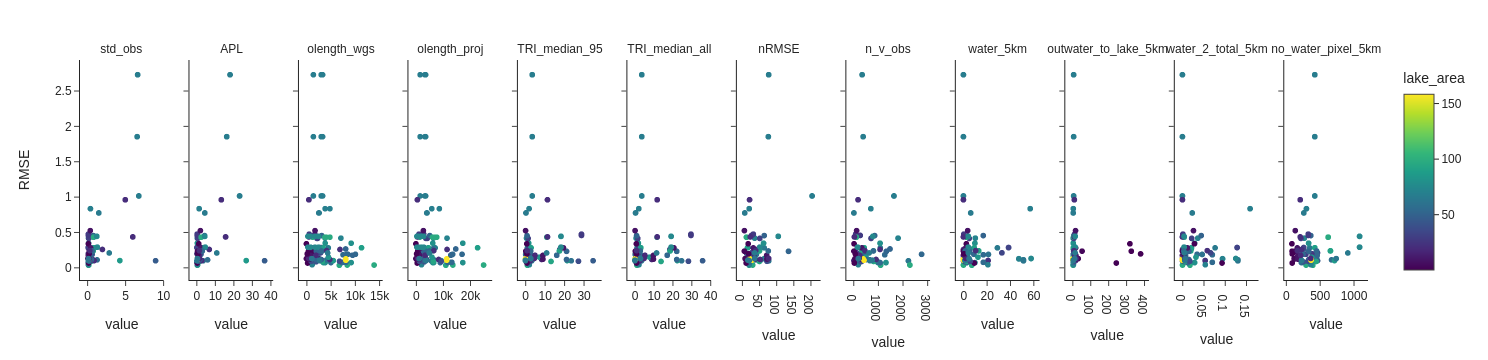

In [186]:
import plotly.express as px
x_fd='value'
y_fd='RMSE'
facet='predictors'
# color='lake_area'
df=df_melt.loc[(df_melt['RMSE']!=df_melt['RMSE'].max())&(df_melt['predictors']!='VE')]

fig = px.scatter(df, x=x_fd, y=y_fd, facet_col=facet,color=color,
                template="simple_white")

fig.update_xaxes(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

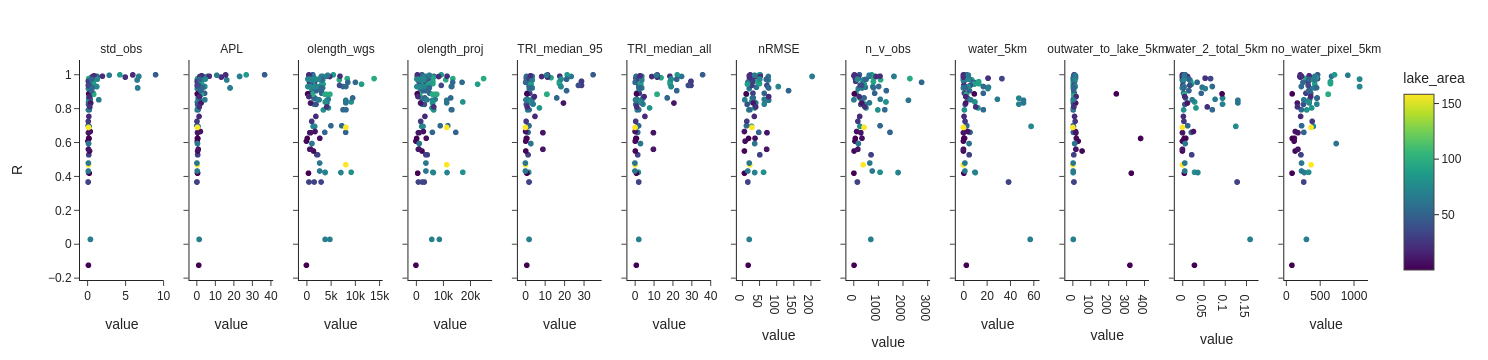

In [187]:
x_fd='value'
y_fd='R'
facet='predictors'
color='lake_area'
df=df_melt.loc[(df_melt['RMSE']!=df_melt['RMSE'].max())&(df_melt['predictors']!='VE')]

fig = px.scatter(df, x=x_fd, y=y_fd, facet_col=facet,color=color,
                template="simple_white")

fig.update_xaxes(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [188]:
corr_pre_fd=predictors+['RMSE','R']

corr=df_final[corr_pre_fd].corr().sort_values(by='RMSE')
corr.style.background_gradient(cmap='coolwarm')

,std_obs,APL,VE,lake_area,olength_wgs,olength_proj,TRI_median_95,TRI_median_all,nRMSE,n_v_obs,water_5km,outwater_to_lake_5km,water_2_total_5km,no_water_pixel_5km,RMSE,R
R,0.279850,0.133259,-0.024726,0.241718,0.097455,0.081242,0.310155,0.310720,0.280560,0.123125,-0.128397,-0.310155,-0.202668,0.363573,-0.462939,1.000000
olength_proj,-0.196670,-0.194625,-0.134790,0.425634,0.981825,1.000000,-0.218418,-0.217910,-0.144491,0.631756,0.055300,-0.233217,0.112247,-0.129843,-0.201101,0.081242
olength_wgs,-0.149202,-0.156769,-0.111893,0.462663,1.000000,0.981825,-0.216586,-0.216088,-0.088896,0.646975,0.064534,-0.254985,0.119563,-0.101685,-0.179744,0.097455
water_2_total_5km,-0.300544,-0.302303,-0.079473,0.033543,0.119563,0.112247,-0.337950,-0.336851,-0.174116,0.104338,0.953760,-0.047771,1.000000,-0.158782,-0.175335,-0.202668
water_5km,-0.275267,-0.273478,-0.129547,0.129889,0.064534,0.055300,-0.271183,-0.269127,-0.117106,0.065600,1.000000,-0.127333,0.953760,-0.020054,-0.173794,-0.128397
n_v_obs,-0.035323,-0.033363,-0.097988,0.317022,0.646975,0.631756,-0.176201,-0.176199,0.326114,1.000000,0.065600,-0.229760,0.104338,-0.066056,-0.153342,0.123125
lake_area,0.044874,0.006345,-0.236421,1.000000,0.462663,0.425634,-0.013796,-0.011172,0.130665,0.317022,0.129889,-0.401186,0.033543,0.509207,-0.129138,0.241718
no_water_pixel_5km,0.126024,0.141642,-0.197749,0.509207,-0.101685,-0.129843,0.395636,0.398941,0.292233,-0.066056,-0.020054,-0.238523,-0.158782,1.000000,-0.075199,0.363573
VE,-0.145011,-0.126655,1.000000,-0.236421,-0.111893,-0.134790,0.300371,0.304473,0.197126,-0.097988,-0.129547,0.094539,-0.079473,-0.197749,-0.053337,-0.024726
TRI_median_all,0.130782,0.193147,0.304473,-0.011172,-0.216088,-0.217910,0.999875,1.000000,0.248681,-0.176199,-0.269127,-0.119807,-0.336851,0.398941,-0.030750,0.310720


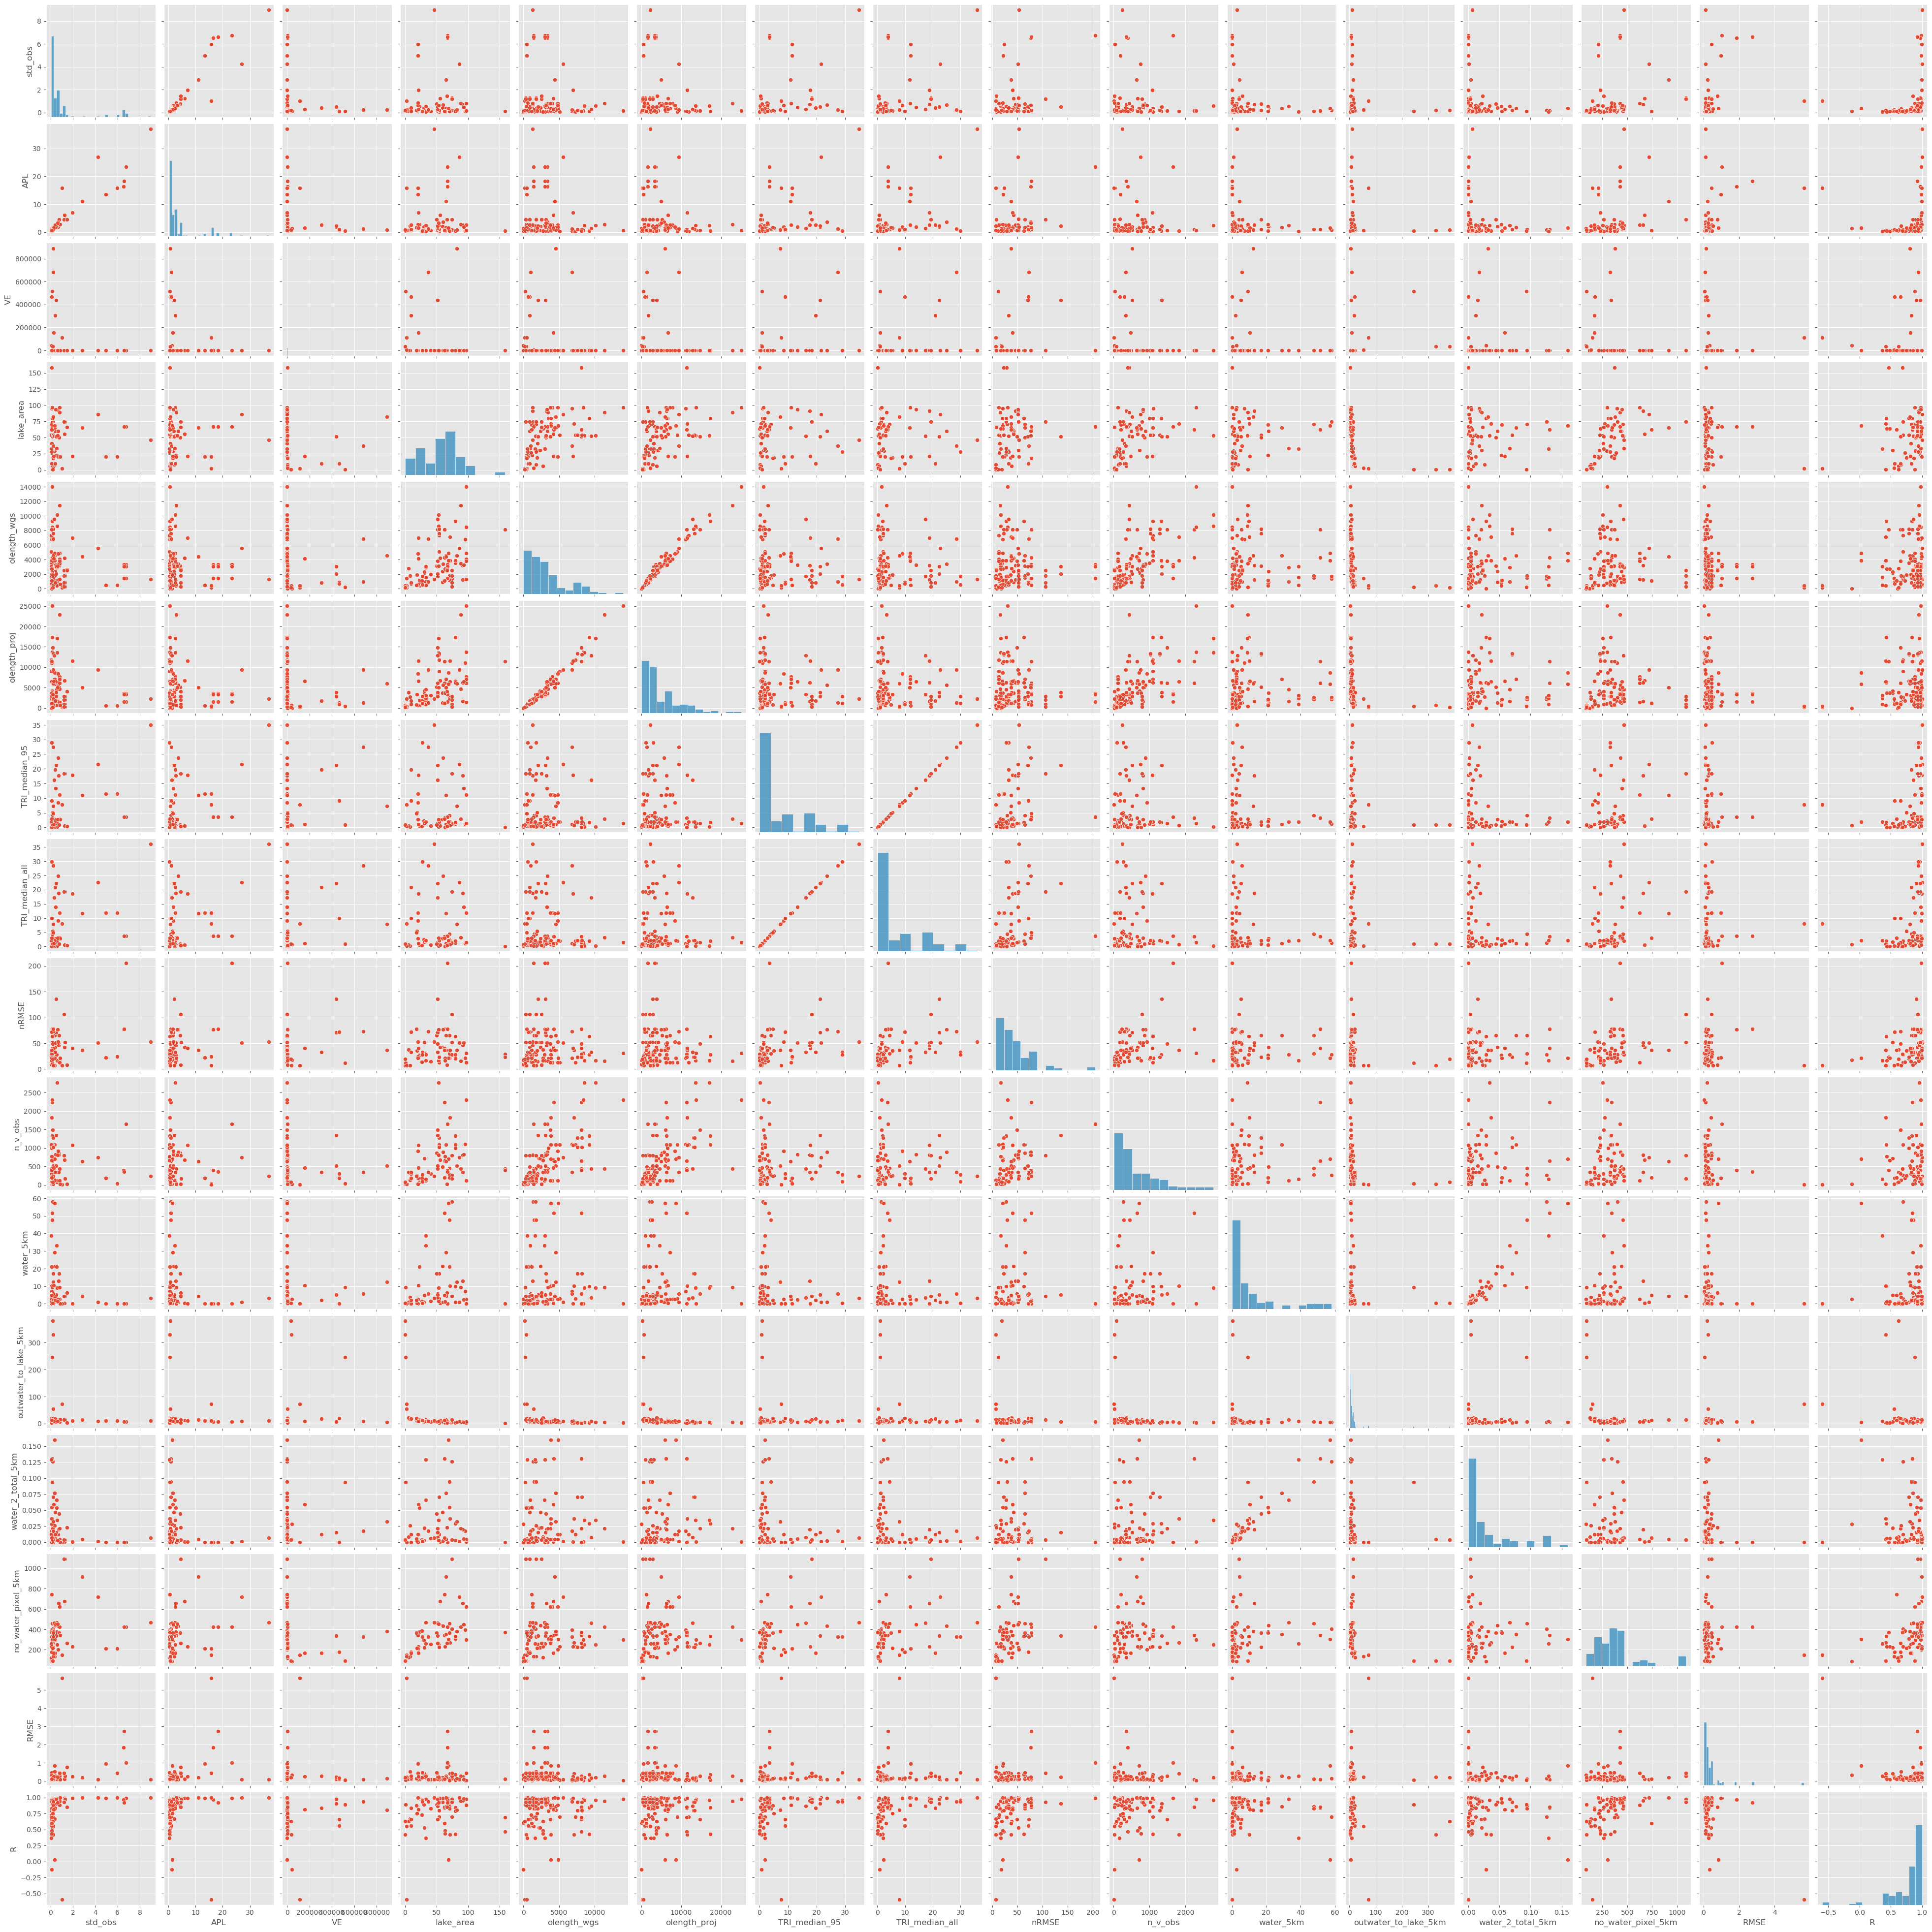

In [160]:
import seaborn as sns
sns.pairplot(df_final[corr_pre_fd])

In [190]:
#Compute VIF data for each independent variable
'''What Is a Variance Inflation Factor (VIF)? (from https://www.investopedia.com/terms/v/variance-inflation-factor.asp)
A variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis. 
Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model. 
This can adversely affect the regression results. Thus, the variance inflation factor can estimate how much the variance of a 
regression coefficient is inflated due to multicollinearity'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = predictors
vif["vif_Factor"] = [variance_inflation_factor(df_final[predictors].values, i) for i in range(df_final[predictors].shape[1])]
vif.sort_values(by='vif_Factor')

,features,vif_Factor
11,outwater_to_lake_5km,1.214747
2,VE,2.110155
9,n_v_obs,5.684678
8,nRMSE,6.330784
13,no_water_pixel_5km,9.358139
3,lake_area,10.054321
1,APL,12.169584
0,std_obs,12.458386
12,water_2_total_5km,24.307526
10,water_5km,24.554864


In [192]:
#From here
#https://xavierbourretsicotte.github.io/subset_selection.html

import itertools
import time
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


In [193]:
#Best subset selection 
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    MSE = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return MSE, R_squared


In [197]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#for each predictor combination calculate the variables of importance
related_area_variable=['water_5km', 'water_2_total_5km']
related_diff_levels=['std_obs','APL']
vars_pred=['lake_area','olength_wgs', 'TRI_median_all','nRMSE','n_v_obs']
response=['RMSE','R']
group=1
df_out_f=pd.DataFrame()
for area_var in related_area_variable:
    for diff_var in related_diff_levels:
        for resp in response:
            new_predictors=[area_var, diff_var]+vars_pred+[resp]
            #Initialization variables
            df=df_final[new_predictors]
            Y = df[resp]
            X = df.drop(columns = resp, axis = 1)
            k = 5
            RSS_list, R_squared_list, feature_list = [],[], []
            numb_features = []
            #Looping over k = 1 to k = 11 features in X
            for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

                #Looping over all possible combinations: from 5 choose k
                for combo in itertools.combinations(X.columns,k):
                    tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
                    RSS_list.append(tmp_result[0])                  #Append lists
                    R_squared_list.append(tmp_result[1])
                    feature_list.append(combo)
                    numb_features.append(len(combo)) 
            #Store in DataFrame
            df_out = pd.DataFrame({'numb_features': numb_features, 'Response_var':resp,
                                   'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list, 'group_p':group})
            df_out_f=pd.concat([df_out_f, df_out], axis=0)
            group=group+1
            # print(group, new_predictors)
df_min = df_out_f[df_out_f.groupby(['numb_features', 'group_p'])['RSS'].transform(min) == df_out_f['RSS']]
df_max = df_out_f[df_out_f.groupby(['numb_features','group_p'])['R_squared'].transform(max) == df_out_f['R_squared']]
display(df_min)
display(df_max)

/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

2 ['water_5km', 'std_obs', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'RMSE']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

3 ['water_5km', 'std_obs', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'R']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

4 ['water_5km', 'APL', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'RMSE']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

5 ['water_5km', 'APL', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'R']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

6 ['water_2_total_5km', 'std_obs', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'RMSE']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

7 ['water_2_total_5km', 'std_obs', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'R']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

8 ['water_2_total_5km', 'APL', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'RMSE']


/tmp/ipykernel_33488/883236815.py:23: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

9 ['water_2_total_5km', 'APL', 'lake_area', 'olength_wgs', 'TRI_median_all', 'nRMSE', 'n_v_obs', 'R']


,numb_features,Response_var,RSS,R_squared,features,group_p
1,1,RMSE,69.854583,0.183233,"(std_obs,)",1
13,2,RMSE,67.968652,0.205284,"(std_obs, lake_area)",1
45,3,RMSE,67.052038,0.216001,"(std_obs, lake_area, nRMSE)",1
87,4,RMSE,66.170132,0.226313,"(std_obs, lake_area, TRI_median_all, n_v_obs)",1
102,5,RMSE,65.816324,0.230449,"(water_5km, std_obs, lake_area, TRI_median_all...",1
122,6,RMSE,65.689764,0.231929,"(water_5km, std_obs, lake_area, TRI_median_all...",1
126,7,RMSE,65.579306,0.233221,"(water_5km, std_obs, lake_area, olength_wgs, T...",1
4,1,R,8.990790,0.096547,"(TRI_median_all,)",2
19,2,R,8.392450,0.156672,"(lake_area, TRI_median_all)",2
44,3,R,7.865658,0.209607,"(std_obs, lake_area, TRI_median_all)",2


,numb_features,Response_var,RSS,R_squared,features,group_p
1,1,RMSE,69.854583,0.183233,"(std_obs,)",1
13,2,RMSE,67.968652,0.205284,"(std_obs, lake_area)",1
45,3,RMSE,67.052038,0.216001,"(std_obs, lake_area, nRMSE)",1
87,4,RMSE,66.170132,0.226313,"(std_obs, lake_area, TRI_median_all, n_v_obs)",1
102,5,RMSE,65.816324,0.230449,"(water_5km, std_obs, lake_area, TRI_median_all...",1
122,6,RMSE,65.689764,0.231929,"(water_5km, std_obs, lake_area, TRI_median_all...",1
126,7,RMSE,65.579306,0.233221,"(water_5km, std_obs, lake_area, olength_wgs, T...",1
4,1,R,8.990790,0.096547,"(TRI_median_all,)",2
19,2,R,8.392450,0.156672,"(lake_area, TRI_median_all)",2
44,3,R,7.865658,0.209607,"(std_obs, lake_area, TRI_median_all)",2


In [ ]:
#Initialization variables

k = 5
# related_area_variable=['area_buffe', 'orbit_leng', 'Lake_area']
# related_diff_levels=['std_obs','APL', 'rb_index', 'std_diff']

# TO-DO Pending to test
group=1
df_out_f=pd.DataFrame()
for area_var in related_area_variable:
    for diff_var in related_diff_levels:
        new_predictors=[area_var, diff_var]+['per_area_c','TRI_mdn']
        X=df_t_3km_vars[new_predictors]
        Y=df_t_3km_vars['value']
        remaining_features = list(X.columns.values)
        features = []
        RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
        features_list = dict()

        for i in range(1,k+1):
            best_RSS = np.inf
    
            for combo in itertools.combinations(remaining_features,1):
                    # print(i,combo)
                    RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

                    if RSS[0] < best_RSS:
                        best_RSS = RSS[0]
                        best_R_squared = RSS[1] 
                        best_feature = combo[0]

            #Updating variables for next loop
            features.append(best_feature)
            remaining_features.remove(best_feature)

            #Saving values for plotting
            RSS_list.append(best_RSS)
            R_squared_list.append(best_R_squared)
            features_list[i] = features.copy()
            # print(features_list[i], 'list')
            df_out = pd.DataFrame({'num_it': i,'RSS': best_RSS, 'R_squared':best_R_squared,'features':[features_list[i]], 'group_p':group})
            # print(df_out.features, 'list df')
            df_out_f=pd.concat([df_out_f, df_out], axis=0)
        group=group+1
        
# df_out_sw = pd.DataFrame({'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [199]:
#Example from https://mljar.com/blog/feature-importance-in-random-forest/

# Let's load the packages
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
# import shap
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})
from matplotlib import style

print(plt.style.available)

related_area_variable=['water_5km', 'water_2_total_5km']
related_diff_levels=['std_obs','APL']
vars_pred=['lake_area','olength_wgs', 'TRI_median_all','nRMSE','n_v_obs']
response=['RMSE','R']

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


/tmp/ipykernel_33488/2886248145.py:15: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



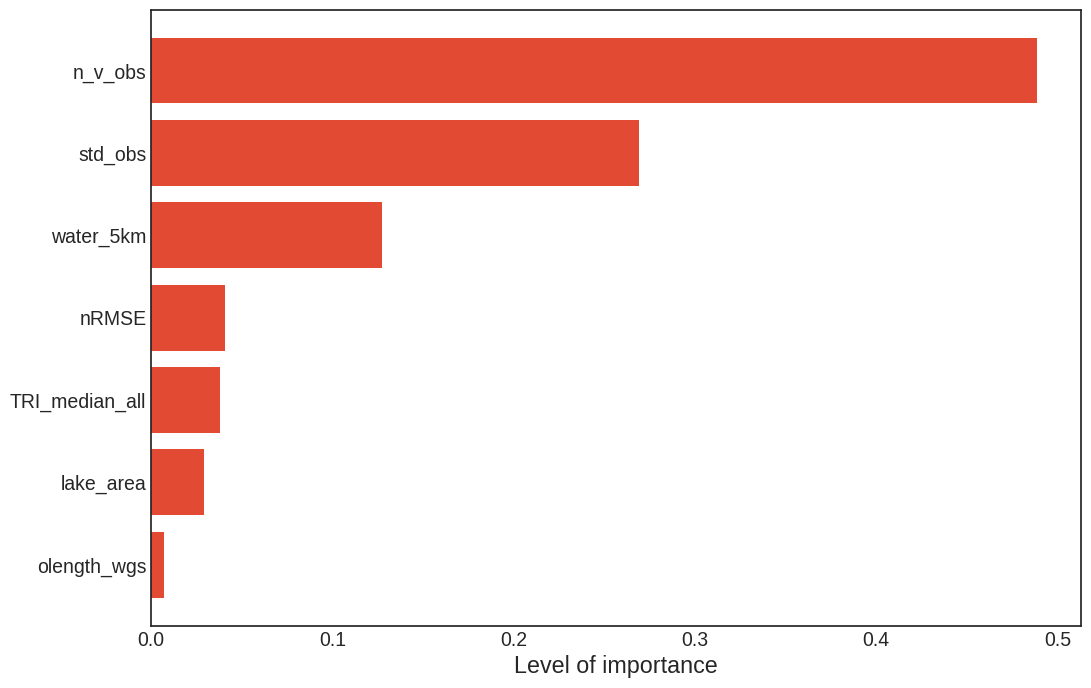

In [205]:
rf = RandomForestRegressor(n_estimators=50) #n_estimator, how many trees to use. 

for area_var in related_area_variable:
    for diff_var in related_diff_levels:
        for resp in response:
            new_predictors=vars_pred+[diff_var, area_var]
            X=df_final[new_predictors]
            Y=df_final[resp]

            rf.fit(X, Y)
        # print(rf.feature_importances_)
        # plt.barh(boston.feature_names, rf.feature_importances_)
            sorted_idx = rf.feature_importances_.argsort()
        # print(X.columns[sorted_idx])
            plt.style.use('seaborn-white')
            plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
            plt.xlabel("Level of importance")
            locs, labels = plt.yticks() 
            # plt.yticks(np.arange(4),['% area orbit/area lake', 'area around orbit', 'Topography roughness', 'SWE variability'])
            # locs.show()
            break
        break
    break

In [ ]:
# for now on, old code

In [166]:
dtale.show(df_final[predictors])
df_final.loc[df_final['lake_area'].isna(),['lake_id','gauge_id']]

,lake_id,gauge_id
91,7.320417e+09,CFN2
93,7.421067e+09,YSL2


,gauge_id,lake_id,sat,RMSE,R,source,orbit,orbit_count,lake_area,predictors,value
0,01AQ007,7.310171e+09,S3B,0.1914,0.8909,K_CA,353.0,1.0,29.75,std_obs,0.381944
1,02BC007,7.250359e+09,S3B,0.1892,0.9261,K_CA,175.0,1.0,59.54,std_obs,0.420022
2,02BC007,7.250359e+09,S3B,0.1892,0.9261,K_CA,311.0,1.0,59.54,std_obs,0.420022
3,02CH002,7.250502e+09,S3B,0.1262,0.8616,K_CA,18.0,1.0,70.35,std_obs,0.143293
4,02CH002,7.250502e+09,S3B,0.1262,0.8616,K_CA,211.0,1.0,70.35,std_obs,0.143293
...,...,...,...,...,...,...,...,...,...,...,...
1035,TAB2,2.200000e+01,S3A,0.7760,0.8520,LOCSS,97.0,1.0,66.10,outwater_to_lake_5km,0.094574
1036,TAB2,2.200000e+01,S3A,0.7760,0.8520,LOCSS,375.0,1.0,66.10,outwater_to_lake_5km,0.094574
1037,19069,1.906900e+04,S3A,0.2100,0.9970,RVBR,95.0,1.0,64.98,outwater_to_lake_5km,0.065968
1038,19126,1.912600e+04,S3A,0.1300,0.5940,RVBR,245.0,1.0,62.36,outwater_to_lake_5km,0.078024


In [78]:
import pandas as pd
df_all= pd.read_csv('C:/Users/amgomez/Downloads/order_importance.csv', sep=',')
df_all
df_area=pd.read_csv('G:/My Drive/data_gee1/Area_WaterLand_5km_Buffer.csv', sep=',')


In [79]:
bff='5km'
cols=['lake_id']
water_ratio_fd='water_to_total_'+bff
df_area[water_ratio_fd]=df_area['waterArea_PA_km2']/df_area['totalArea_PA_km2']
df_area[['lake_id',water_ratio_fd]]
cols.extend([water_ratio_fd])
cols[-1:]

['water_to_total_5km']

In [80]:
cols.extend(['waterArea_PA_km2'])
cols

['lake_id', 'water_to_total_5km', 'waterArea_PA_km2']

In [81]:
predictors=['std_obs',	'APL','VE','olength_wgs','olength_proj','TRI_median']
predictors.extend(cols[-1:])
predictors

['std_obs',
 'APL',
 'VE',
 'olength_wgs',
 'olength_proj',
 'TRI_median',
 'waterArea_PA_km2']

In [82]:
df_all=pd.merge(df_all,df_area[cols], on='lake_id', how='left')
df_all

,Unnamed: 0,gauge_id,lake_id,sat,RMSE,nRMSE,R,source,std_obs,APL,VE,orbit,lake_area,olength_wgs,olength_proj,orbit_count,TRI_median,water_to_total_5km,waterArea_PA_km2
0,0,01AQ007,7.310171e+09,S3B,0.1914,32,0.8909,K_CA,0.381944,1.853004,0.124754,353.0,29.75,764.807808,1030.142397,1.0,2.266622,0.002816,0.831197
1,1,02BC007,7.250359e+09,S3B,0.1892,42,0.9261,K_CA,0.420022,2.034000,0.205534,175.0,59.54,874.909381,1292.981681,1.0,2.660516,0.046604,21.460239
2,2,02BC007,7.250359e+09,S3B,0.1892,42,0.9261,K_CA,0.420022,2.034000,0.205534,311.0,59.54,2422.712903,3639.267955,1.0,2.660516,0.046604,21.460239
3,3,02CH002,7.250502e+09,S3B,0.1262,30,0.8616,K_CA,0.143293,0.969002,0.236958,18.0,70.35,1528.300075,2173.288085,1.0,4.035700,0.094558,47.612842
4,4,02CH002,7.250502e+09,S3B,0.1262,30,0.8616,K_CA,0.143293,0.969002,0.236958,211.0,70.35,1805.448698,2647.404951,1.0,4.035700,0.094558,47.612842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,125,TAB2,2.200000e+01,S3A,0.7760,8,0.8520,LOCSS,1.476158,4.589000,2477.169000,97.0,66.10,2627.689627,4113.289926,1.0,0.383667,0.023198,6.251322
126,126,TAB2,2.200000e+01,S3A,0.7760,8,0.8520,LOCSS,1.476158,4.589000,2477.169000,375.0,66.10,2547.633014,3998.771359,1.0,0.383667,0.023198,6.251322
127,127,19069,1.906900e+04,S3A,0.2100,37,0.9970,RVBR,2.852704,11.057000,36.975000,95.0,64.98,4392.409413,4972.418992,1.0,11.008511,0.004663,4.286602
128,128,19126,1.912600e+04,S3A,0.1300,37,0.5940,RVBR,0.122372,0.600000,104.674000,245.0,62.36,1146.301497,1240.071031,1.0,2.888542,0.006512,4.865586


In [83]:
out_w_2_lake_fd='outwater_to_lake_'+bff
df_all[out_w_2_lake_fd]=df_all['waterArea_PA_km2']/df_all['lake_area']

In [65]:
df_all

,Unnamed: 0,gauge_id,lake_id,sat,RMSE,nRMSE,R,source,std_obs,APL,VE,orbit,lake_area,olength_wgs,olength_proj,orbit_count,TRI_median,water_to_total_5km,waterArea_PA_km2,outwater_to_lake_5km
0,0,01AQ007,7.310171e+09,S3B,0.1914,32,0.8909,K_CA,0.381944,1.853004,0.124754,353.0,29.75,764.807808,1030.142397,1.0,2.266622,0.002816,0.831197,0.027939
1,1,02BC007,7.250359e+09,S3B,0.1892,42,0.9261,K_CA,0.420022,2.034000,0.205534,175.0,59.54,874.909381,1292.981681,1.0,2.660516,0.046604,21.460239,0.360434
2,2,02BC007,7.250359e+09,S3B,0.1892,42,0.9261,K_CA,0.420022,2.034000,0.205534,311.0,59.54,2422.712903,3639.267955,1.0,2.660516,0.046604,21.460239,0.360434
3,3,02CH002,7.250502e+09,S3B,0.1262,30,0.8616,K_CA,0.143293,0.969002,0.236958,18.0,70.35,1528.300075,2173.288085,1.0,4.035700,0.094558,47.612842,0.676799
4,4,02CH002,7.250502e+09,S3B,0.1262,30,0.8616,K_CA,0.143293,0.969002,0.236958,211.0,70.35,1805.448698,2647.404951,1.0,4.035700,0.094558,47.612842,0.676799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,125,TAB2,2.200000e+01,S3A,0.7760,8,0.8520,LOCSS,1.476158,4.589000,2477.169000,97.0,66.10,2627.689627,4113.289926,1.0,0.383667,0.023198,6.251322,0.094574
126,126,TAB2,2.200000e+01,S3A,0.7760,8,0.8520,LOCSS,1.476158,4.589000,2477.169000,375.0,66.10,2547.633014,3998.771359,1.0,0.383667,0.023198,6.251322,0.094574
127,127,19069,1.906900e+04,S3A,0.2100,37,0.9970,RVBR,2.852704,11.057000,36.975000,95.0,64.98,4392.409413,4972.418992,1.0,11.008511,0.004663,4.286602,0.065968
128,128,19126,1.912600e+04,S3A,0.1300,37,0.5940,RVBR,0.122372,0.600000,104.674000,245.0,62.36,1146.301497,1240.071031,1.0,2.888542,0.006512,4.865586,0.078024


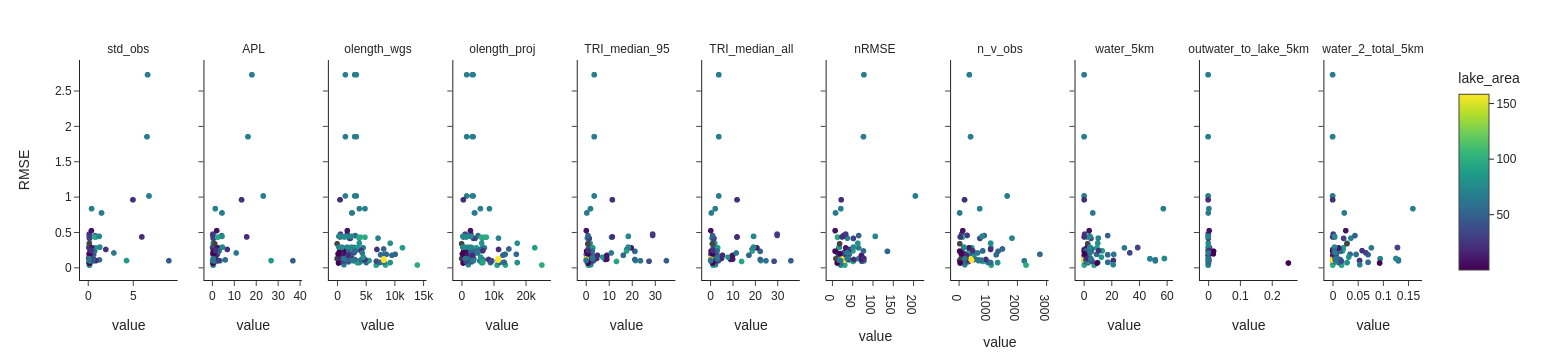

In [113]:
import plotly.express as px
x_fd='value'
y_fd='RMSE'
facet='predictors'
color='lake_area'
df=df_melt.loc[(df_melt['RMSE']!=df_melt['RMSE'].max())&(df_melt['predictors']!='VE')]

fig = px.scatter(df, x=x_fd, y=y_fd, facet_col=facet,color=color,
                template="simple_white")

fig.update_xaxes(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [ ]:
#take the selected fields and merge results from karina and result from us
#selected fields R, RMSE, gauge_id, lake_id, n_obs, sat, 

In [85]:
corr_fd=predictors
corr_fd.extend(['lake_area'])
corr=df_all[corr_fd].corr()
corr.style.background_gradient(cmap='coolwarm')

,std_obs,APL,VE,olength_wgs,olength_proj,TRI_median,waterArea_PA_km2,outwater_to_lake_5km,lake_area
std_obs,1.000000,0.934827,-0.145011,-0.149202,-0.196670,0.135156,-0.275267,-0.088855,0.031208
APL,0.934827,1.000000,-0.126655,-0.156769,-0.194625,0.197702,-0.273478,-0.093177,-0.007153
VE,-0.145011,-0.126655,1.000000,-0.111893,-0.134790,0.300371,-0.129547,0.230741,-0.247982
olength_wgs,-0.149202,-0.156769,-0.111893,1.000000,0.981825,-0.216586,0.064534,-0.110184,0.446790
olength_proj,-0.196670,-0.194625,-0.134790,0.981825,1.000000,-0.218418,0.055300,-0.098886,0.410832
TRI_median,0.135156,0.197702,0.300371,-0.216586,-0.218418,1.000000,-0.271183,-0.120815,-0.036877
waterArea_PA_km2,-0.275267,-0.273478,-0.129547,0.064534,0.055300,-0.271183,1.000000,0.106840,0.116620
outwater_to_lake_5km,-0.088855,-0.093177,0.230741,-0.110184,-0.098886,-0.120815,0.106840,1.000000,-0.193374
lake_area,0.031208,-0.007153,-0.247982,0.446790,0.410832,-0.036877,0.116620,-0.193374,1.000000


In [48]:

df_results['name_altis'] = df_results['name_altis'].apply(lambda x: x.strip())

df_merged=pd.merge(df_results,df_shp_lenghts, left_on='name_altis', right_on='VS', how='left')
# df_merged=df_merged.loc[df_merged['source_x']=='LOCSS']
# df_merged=df_merged.loc[~(df_merged['USE'].isnull())]
# df_merged=df_merged.loc[df_merged['USE']!='N']
df_merged.columns#shape
# df_merged.loc[df_merged['r2'].notna()]
# df_merged[['station','lake_name','orbit_leng','Lake_area', 'RHO', 'area_buffe']]
df_merged=df_merged.rename(columns={'lake_name_x':'lake_name'})
df_merged[['station','name_altis','VS','lake_name','lake_name_y','orbit_leng','Lake_area', 'RHO', 'area_buffe']].sort_values(by='station')

,station,name_altis,VS,lake_name,lake_name_y,orbit_leng,Lake_area,RHO,area_buffe
0,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.993,6.766995
1,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
2,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
3,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
4,12030,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,Açude Araras,Aï¿½ude Araras,1442.903457,67.41,0.975,2.929606
5,12030,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,Açude Araras,Aï¿½ude Araras,3055.960550,67.41,0.975,5.752967
6,12036,AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_016...,AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_016...,Açude Atalho,Aï¿½ude Atalho,527.182114,7.91,0.955,1.141536
7,12036,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,Açude Atalho,Atalho,495.253963,7.91,0.989,0.704895
8,12327,AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901,NaN,Açude Petrônio Portela,NaN,NaN,NaN,0.994,NaN
20,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,Lago Mascardi,Lago Mascardi,1010.538390,36.62,0.924,2.051678


In [12]:
df_merged.loc[df_merged['station']=='12036', ['result_id','RHO', 'altis', 'VS']].values
# AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765
# AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765

array([[5, 0.955,
        '12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764',
        'AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764'],
       [7, 0.989, '12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765',
        'AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765']], dtype=object)

In [49]:
#fixing manually until I figure out why the merged is not working
df_merged.loc[df_merged['station']=='CFN2','orbit_leng' ]=0
# df_merged.loc[df_merged['station']=='CFN2','lake_name' ]='Catfish'
df_merged.loc[df_merged['station']=='CFN2','Lake_area' ]=3.72
df_merged.loc[df_merged['station']=='CFN2','area_buffe' ]=0

df_merged.loc[df_merged['station']=='YSL2','orbit_leng' ]=0
# df_merged.loc[df_merged['station']=='YSL2','lake_name' ]='Grays'
df_merged.loc[df_merged['station']=='YSL2','Lake_area' ]=0.27
df_merged.loc[df_merged['station']=='YSL2','area_buffe' ]=0

df_merged.loc[df_merged['station']=='MTN2','Lake_area' ]=159.97
df_merged.loc[df_merged['station']=='MTN2','area_buffe' ]=16.46
df_merged.loc[df_merged['station']=='MTN2','orbit_leng' ]=8332.24

df_merged.loc[df_merged['station']=='VCN2','Lake_area' ]=159.97
df_merged.loc[df_merged['station']=='VCN2','area_buffe' ]=16.46
df_merged.loc[df_merged['station']=='VCN2','orbit_leng' ]=8332.24

df_merged.loc[df_merged['station']=='BLB2','Lake_area' ]=7.4
df_merged.loc[df_merged['station']=='BLB2','area_buffe' ]=3.67
df_merged.loc[df_merged['station']=='BLB2','orbit_leng' ]=1778.06

df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','Lake_area' ]=8.9
df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','area_buffe' ]=1.178
df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','orbit_leng' ]=639.37

df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','Lake_area' ]=20.44
df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','area_buffe' ]=1.21
df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','orbit_leng' ]=626.28

#I don't get why this doesnt work
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','Lake_area' ]=7.91
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','area_buffe' ]=0.71
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','orbit_leng' ]=495.25

#The difference with name_altis and VS is the word new
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','Lake_area' ]=64.98
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','area_buffe' ]=3.95
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','orbit_leng' ]=4392.4

df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','Lake_area' ]=64.98
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','area_buffe' ]=3.95
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','orbit_leng' ]=4392.4


#Exclude RAW2
df_merged=df_merged.loc[df_merged['station']!='RAW2']
df_merged['per_area_c']=df_merged['area_buffe']/df_merged['Lake_area']

#Format all the names 
df_merged['lake_name']=df_merged['lake_name'].str.replace('Lake', '')
df_merged[['station','lake_name','orbit_leng','Lake_area', 'RHO', 'per_area_c', 'APL', 'mean_diff']]

,station,lake_name,orbit_leng,Lake_area,RHO,per_area_c,APL,mean_diff
0,12030,Açude Araras,3350.299028,67.41,0.993,0.100386,23.423,-0.078971
1,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
2,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
3,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
4,12030,Açude Araras,1442.903457,67.41,0.975,0.043460,16.456,0.000395
5,12030,Açude Araras,3055.960550,67.41,0.975,0.085343,16.456,0.000395
6,12036,Açude Atalho,527.182114,7.91,0.955,0.144316,13.516,-0.082857
7,12036,Açude Atalho,495.250000,7.91,0.989,0.089760,15.845,0.645556
8,12327,Açude Petrônio Portela,626.280000,20.44,0.994,0.059198,2.861,0.015000
9,BLB2,Balashur,1778.060000,7.40,0.607,0.495946,2.197,0.215000


In [50]:
cols=['Lake_area','lake_name','area_buffe','new_area_l','orbit_leng','station','altis','name_altis','rb_index', 'std_diff','mean_diff','std_obs','per_area_c','source_x','RHO', 'NSF','RMSE', 'APL', 'VE', 'n_obs']

df_t=pd.melt(df_merged[cols], id_vars=['Lake_area','lake_name','area_buffe','new_area_l','orbit_leng','station','altis','name_altis','rb_index', 'std_diff','std_obs','mean_diff','per_area_c','source_x','APL', 'VE', 'n_obs'], 
             value_vars=['RHO', 'NSF','RMSE'], ignore_index=True)
df_t['mission']=[x.split('_')[2] for x in df_t['altis']]

# dtale.show(df_t)

In [51]:
#Load TRI 1 and 3 km
# df_stats_1km=pd.read_csv('../data/results/TRI_stats_1km.csv', sep=',')
df_stats_3km=pd.read_csv('../data/results/TRI_stats_3km_2.csv', sep=',')
df_t_3km=pd.merge(df_t, df_stats_3km, left_on='station', right_on='gauge_id', how='left')

In [52]:
df_t_3km=df_t_3km.rename(columns={'median':'TRI_mdn'})

In [53]:
df_t_3km.loc[df_t_3km['station']=='VCN2','TRI_mdn' ]=df_t_3km.loc[df_t_3km['station']=='MTN2','TRI_mdn' ].values[0]
df_t_3km.loc[df_t_3km['station']=='FDN2','TRI_mdn' ]=df_t_3km.loc[df_t_3km['station']=='PHN2','TRI_mdn' ].values[0]

In [18]:
df_t_3km.loc[df_t_3km['station'].isin(['VCN2', 'FDN2', 'MTN2', 'PHN2'])]

,Lake_area,lake_name,area_buffe,new_area_l,orbit_leng,station,altis,name_altis,rb_index,std_diff,...,value,mission,Unnamed: 0,gauge_id,TRI_mdn,mean,max,min,count,std
24,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.609,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
25,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,0.376,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623
26,63.07,Phelps,4.21484,63.071218,2651.700652,FDN2,FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.014337,0.031919,...,0.267,TimeSeries,NaN,NaN,2.449490,NaN,NaN,NaN,NaN,NaN
27,63.07,Phelps East,4.21484,63.071218,2651.700652,PHN2,PHN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.013364,0.125769,...,0.471,TimeSeries,26.0,PHN2,2.449490,2.562359,4.000000,1.0,130313.0,0.762211
67,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.447,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
68,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,-0.005,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623
69,63.07,Phelps,4.21484,63.071218,2651.700652,FDN2,FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.014337,0.031919,...,-0.089,TimeSeries,NaN,NaN,2.449490,NaN,NaN,NaN,NaN,NaN
70,63.07,Phelps East,4.21484,63.071218,2651.700652,PHN2,PHN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.013364,0.125769,...,-0.407,TimeSeries,26.0,PHN2,2.449490,2.562359,4.000000,1.0,130313.0,0.762211
110,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.108,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
111,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,0.127,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623


In [59]:
df_t_3km_vars=df_t_3km.loc[df_t_3km['variable']=='RHO'].copy()

#claculate the variability of the water level 
df_t_3km_vars['wse_var']=df_t_3km_vars['std_diff']/df_t_3km_vars['mean_diff']

predictors=['Lake_area','wse_var','orbit_leng', 'area_buffe','per_area_c','TRI_mdn','APL', 'n_obs', 'rb_index', 'std_diff','mean_diff', 'std_obs']
df_predictors=df_t_3km_vars[predictors].copy()
outcome=df_t_3km_vars['value'].to_numpy().copy()

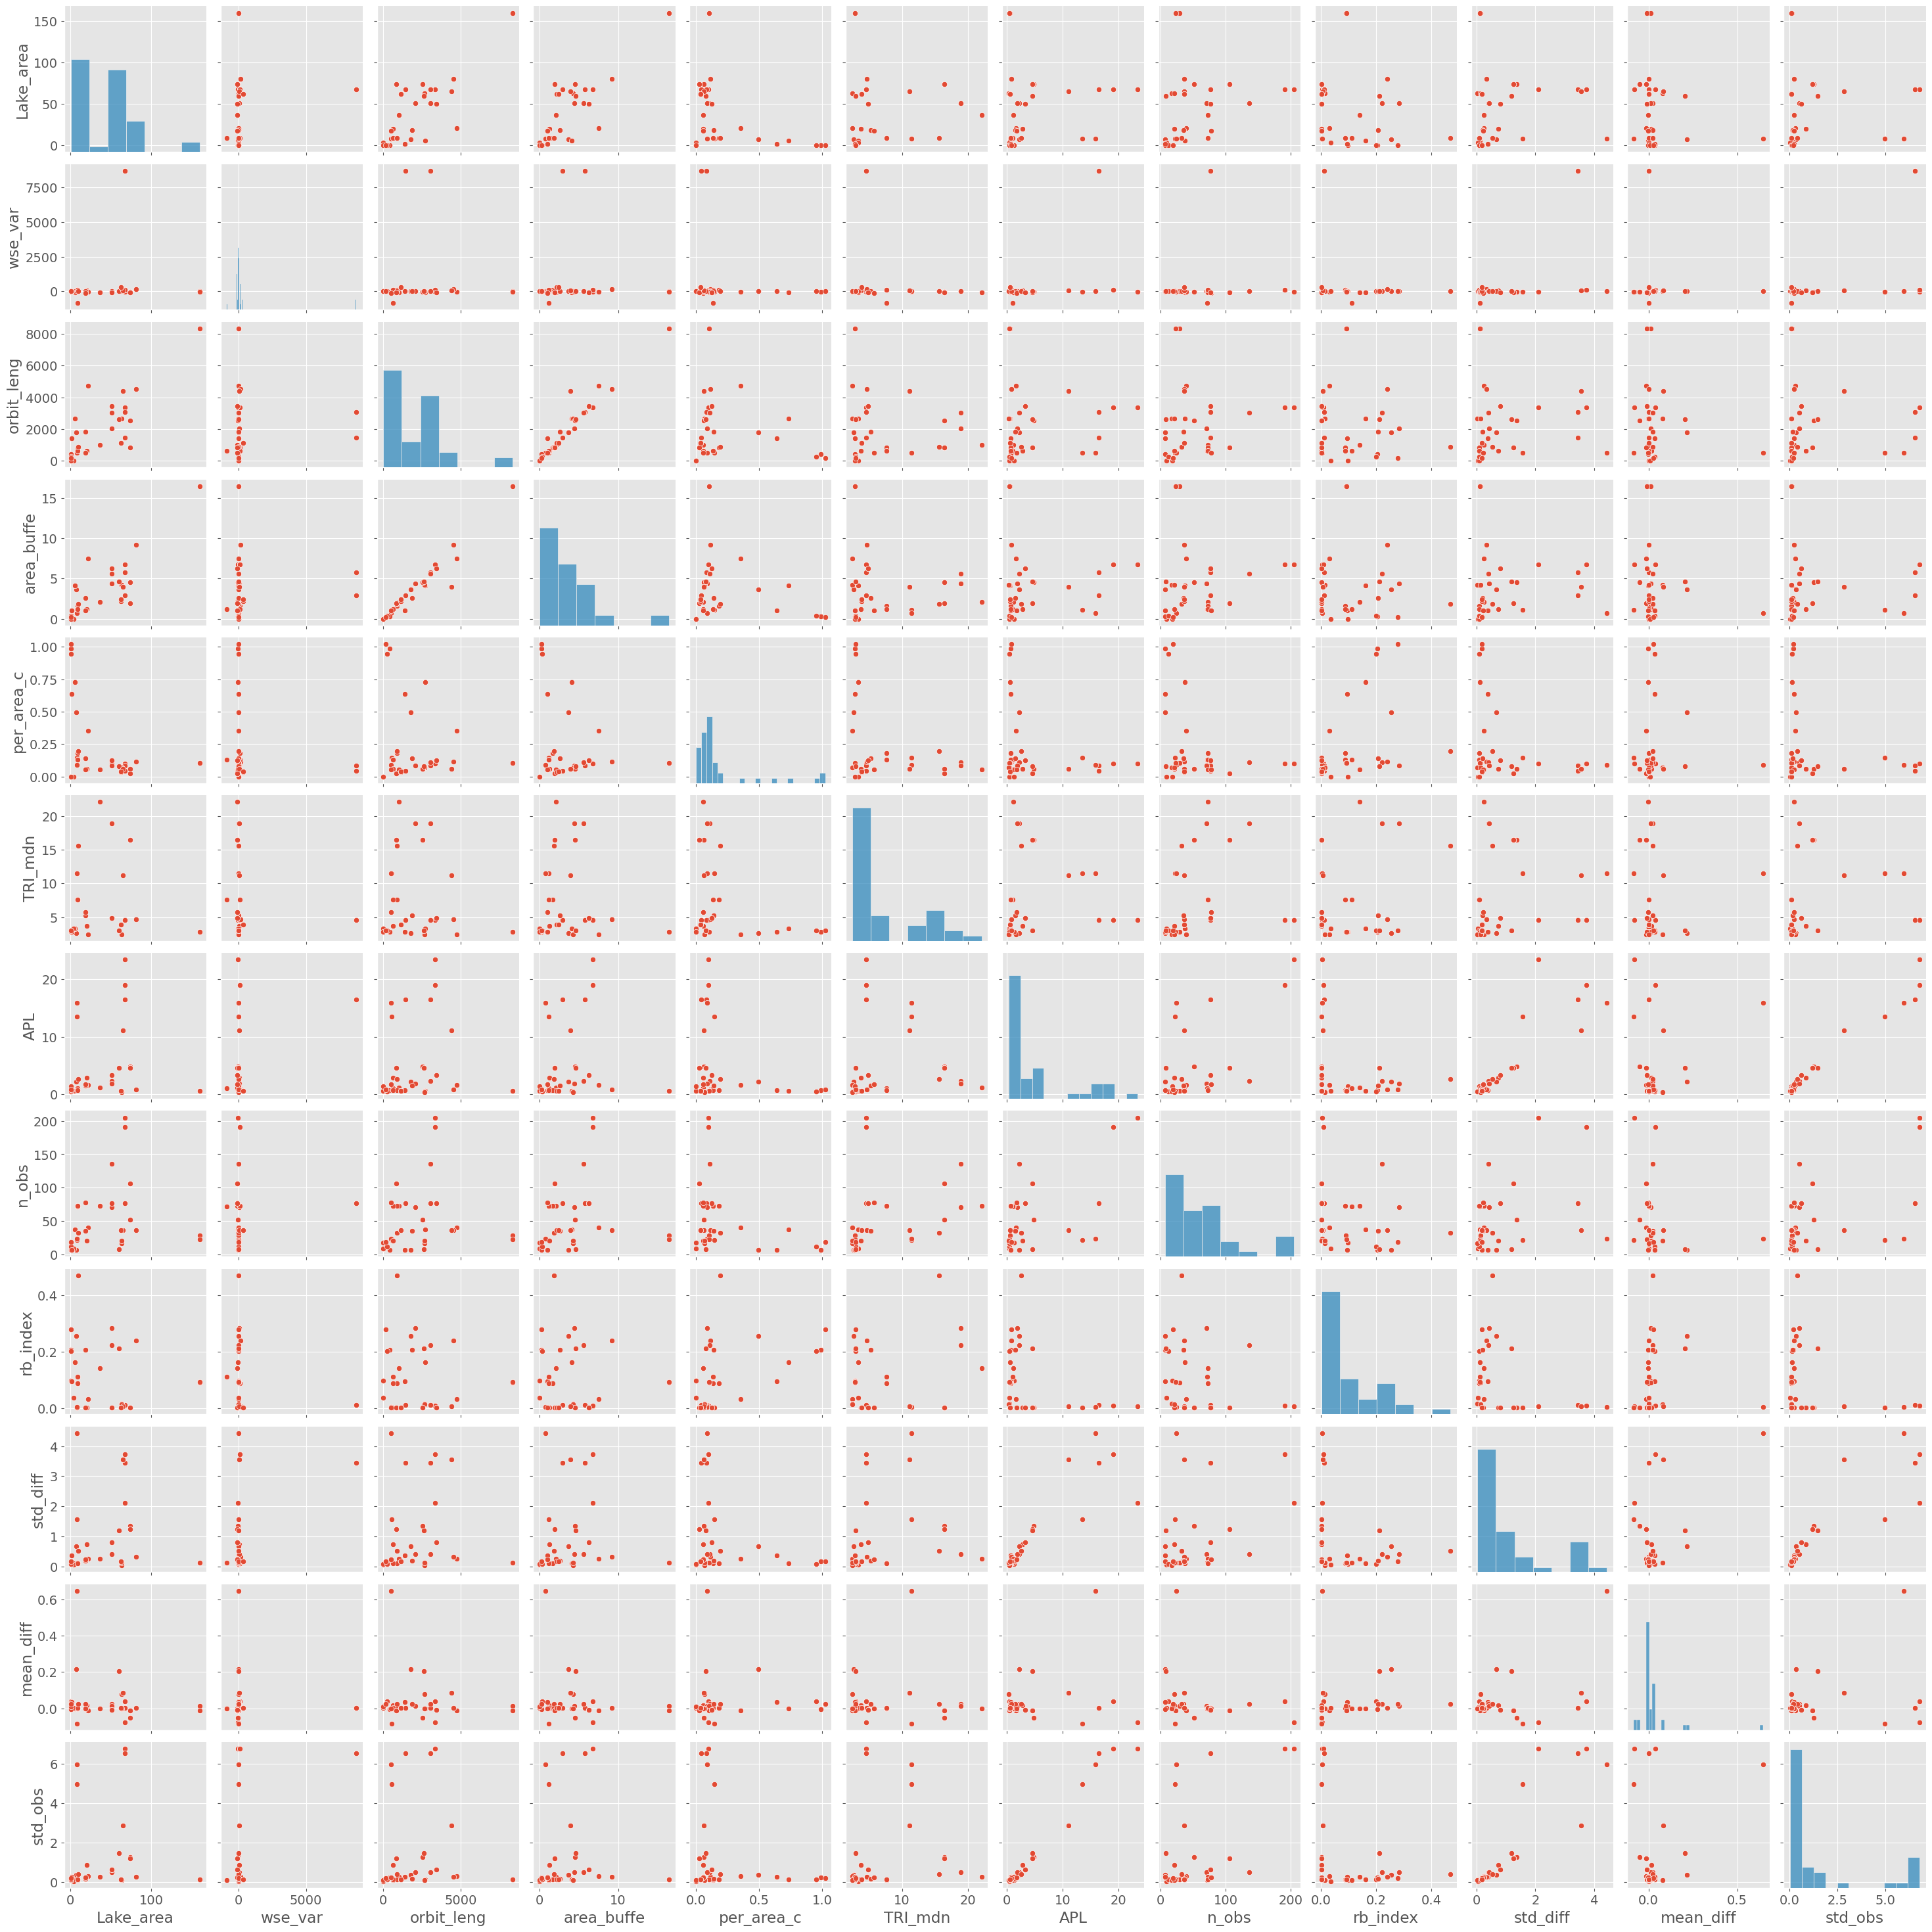

In [60]:
import seaborn as sns
sns.pairplot(df_predictors)


,Unnamed: 0.1,Lake_area,lake_name,area_buffe,new_area_l,orbit_leng,station,altis,name_altis,rb_index,...,mission,Unnamed: 0,gauge_id,TRI_mdn,mean,max,min,count,std,wse_var
0,0,67.41,Açude Araras,6.766995,67.705748,3350.299028,12030,12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,0.005383,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,-26.767512
1,1,67.41,Açude Araras,6.766995,67.705748,3350.299028,12030,12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,0.009035,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,98.954233
2,2,67.41,Açude Araras,6.766995,67.705748,3350.299028,12030,12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,0.009035,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,98.954233
3,3,67.41,Açude Araras,6.766995,67.705748,3350.299028,12030,12030_AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,0.009035,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,98.954233
4,4,67.41,Açude Araras,2.929606,67.705748,1442.903457,12030,12030_AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,0.011814,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,8720.262197
5,5,67.41,Açude Araras,5.752967,67.705748,3055.960550,12030,12030_AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,0.011814,...,TimeSeries,0.0,12030,4.582576,4.709094,8.426149,1.0,262907.0,1.657993,8720.262197
6,6,7.91,Açude Atalho,1.141536,4.708346,527.182114,12036,12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Te...,AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_016...,0.001535,...,TimeSeries,1.0,12036,11.445523,11.817531,22.226110,1.0,109303.0,4.656494,-18.941380
7,7,7.91,Açude Atalho,0.710000,4.708346,495.250000,12036,12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S...,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,0.004307,...,TimeSeries,1.0,12036,11.445523,11.817531,22.226110,1.0,109303.0,4.656494,6.862658
8,8,20.44,Açude Petrônio Portela,1.210000,NaN,626.280000,12327,12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S...,AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901,0.001412,...,TimeSeries,3.0,12327,3.741658,3.923342,7.874008,1.0,203075.0,1.555820,49.909028
9,9,7.40,Balashur,3.670000,NaN,1778.060000,BLB2,BLB2_AlTiS_TimeSeries_Sentinel-3A_0636_N2354,AlTiS_TimeSeries_Sentinel-3A_0636_N2354,0.255061,...,TimeSeries,14.0,BLB2,2.645751,2.689648,4.472136,1.0,69396.0,0.848612,3.084619


In [61]:
#correlation matrix
corr=df_t_3km_vars[predictors+['value']].corr()
corr.style.background_gradient(cmap='coolwarm')
# https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea

,Lake_area,wse_var,orbit_leng,area_buffe,per_area_c,TRI_mdn,APL,n_obs,rb_index,std_diff,mean_diff,std_obs,value
Lake_area,1.000000,0.145083,0.777949,0.816940,-0.467495,0.072184,0.183203,0.279501,-0.304935,0.203017,-0.179593,0.174345,0.095077
wse_var,0.145083,1.000000,0.020866,0.035342,-0.111985,-0.128514,0.390731,0.060404,-0.157118,0.419085,-0.052212,0.468879,0.193867
orbit_leng,0.777949,0.020866,1.000000,0.973668,-0.182052,-0.199756,0.115418,0.141853,-0.093458,0.111799,-0.100128,0.098050,-0.010066
area_buffe,0.816940,0.035342,0.973668,1.000000,-0.218678,-0.181761,0.131922,0.208757,-0.070370,0.092594,-0.122760,0.123393,0.001538
per_area_c,-0.467495,-0.111985,-0.182052,-0.218678,1.000000,-0.319820,-0.249460,-0.321212,0.466011,-0.265400,0.022837,-0.228341,-0.219861
TRI_mdn,0.072184,-0.128514,-0.199756,-0.181761,-0.319820,1.000000,0.014714,0.233777,0.097006,0.096044,-0.038960,-0.016923,0.479265
APL,0.183203,0.390731,0.115418,0.131922,-0.249460,0.014714,1.000000,0.663837,-0.390079,0.914498,0.169979,0.987965,0.535707
n_obs,0.279501,0.060404,0.141853,0.208757,-0.321212,0.233777,0.663837,1.000000,-0.304826,0.527183,-0.204727,0.616564,0.478475
rb_index,-0.304935,-0.157118,-0.093458,-0.070370,0.466011,0.097006,-0.390079,-0.304826,1.000000,-0.397999,0.078554,-0.386346,-0.121950
std_diff,0.203017,0.419085,0.111799,0.092594,-0.265400,0.096044,0.914498,0.527183,-0.397999,1.000000,0.376869,0.922860,0.565812


In [23]:
new_predictors=['area_buffe', 'per_area_c','TRI_mdn', 'std_obs','mean_diff', 'value']
new_corr=df_t_3km_vars[new_predictors].corr()
new_corr.style.background_gradient(cmap='coolwarm')

,area_buffe,per_area_c,TRI_mdn,std_obs,mean_diff,value
area_buffe,1.000000,-0.218678,-0.181761,0.123393,-0.122760,0.001538
per_area_c,-0.218678,1.000000,-0.319820,-0.228341,0.022837,-0.219861
TRI_mdn,-0.181761,-0.319820,1.000000,-0.016923,-0.038960,0.479265
std_obs,0.123393,-0.228341,-0.016923,1.000000,0.201537,0.511688
mean_diff,-0.122760,0.022837,-0.038960,0.201537,1.000000,0.061921
value,0.001538,-0.219861,0.479265,0.511688,0.061921,1.000000


In [62]:
time_file=datetime.now().strftime("%Y%m%d_%H_%M")
df_t_3km_vars.to_csv('../data/results/to_importance_3km_bf_'+time_file+'.csv', sep=',')


In [44]:
df_t_3km_vars.columns

Index(['Unnamed: 0.1', 'Lake_area', 'lake_name', 'area_buffe', 'new_area_l',
       'orbit_leng', 'station', 'altis', 'name_altis', 'rb_index', 'std_diff',
       'std_obs', 'mean_diff', 'per_area_c', 'source_x', 'APL', 'VE', 'n_obs',
       'variable', 'value', 'mission', 'Unnamed: 0', 'gauge_id', 'TRI_mdn',
       'mean', 'max', 'min', 'count', 'std', 'wse_var'],
      dtype='object')

In [63]:
time_file

'20221210_15_55'

### Load data to evaluate

In [40]:
#Load data from here so it is not done again

df_t_3km_vars=pd.read_csv('../data/results/to_importance_3km_bf_20221210_15_55.csv', sep=',')
predictors=['Lake_area','orbit_leng', 'area_buffe','per_area_c', 'wse_var','TRI_mdn','APL', 'n_obs', 'rb_index', 'std_diff','mean_diff', 'std_obs']


### Extract highly correlated values

In [41]:

corr=df_t_3km_vars[predictors+['value']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Lake_area,orbit_leng,area_buffe,per_area_c,wse_var,TRI_mdn,APL,n_obs,rb_index,std_diff,mean_diff,std_obs,value
Lake_area,1.000000,0.777949,0.816940,-0.467495,0.145083,0.072184,0.183203,0.279501,-0.304935,0.203017,-0.179593,0.174345,0.095077
orbit_leng,0.777949,1.000000,0.973668,-0.182052,0.020866,-0.199756,0.115418,0.141853,-0.093458,0.111799,-0.100128,0.098050,-0.010066
area_buffe,0.816940,0.973668,1.000000,-0.218678,0.035342,-0.181761,0.131922,0.208757,-0.070370,0.092594,-0.122760,0.123393,0.001538
per_area_c,-0.467495,-0.182052,-0.218678,1.000000,-0.111985,-0.319820,-0.249460,-0.321212,0.466011,-0.265400,0.022837,-0.228341,-0.219861
wse_var,0.145083,0.020866,0.035342,-0.111985,1.000000,-0.128514,0.390731,0.060404,-0.157118,0.419085,-0.052212,0.468879,0.193867
TRI_mdn,0.072184,-0.199756,-0.181761,-0.319820,-0.128514,1.000000,0.014714,0.233777,0.097006,0.096044,-0.038960,-0.016923,0.479265
APL,0.183203,0.115418,0.131922,-0.249460,0.390731,0.014714,1.000000,0.663837,-0.390079,0.914498,0.169979,0.987965,0.535707
n_obs,0.279501,0.141853,0.208757,-0.321212,0.060404,0.233777,0.663837,1.000000,-0.304826,0.527183,-0.204727,0.616564,0.478475
rb_index,-0.304935,-0.093458,-0.070370,0.466011,-0.157118,0.097006,-0.390079,-0.304826,1.000000,-0.397999,0.078554,-0.386346,-0.121950
std_diff,0.203017,0.111799,0.092594,-0.265400,0.419085,0.096044,0.914498,0.527183,-0.397999,1.000000,0.376869,0.922860,0.565812


In [51]:
##Just to make the color map prettyish
gmap = np.array([[1,2,3], [2,3,4], [3,4,5]])
df_agu=df_t_3km_vars.copy()
df_agu=df_agu.rename(columns={'Lake_area': 'Lake area','orbit_leng': 'Orbit length', 'area_buffe': 'Area orbit','per_area_c': 'Area orbit/Area lake'})
corr=df_agu[['Lake area', 'Orbit length', 'Area orbit','Area orbit/Area lake']].corr()
corr.style.background_gradient(
    cmap='coolwarm'
) 

,Lake area,Orbit length,Area orbit,Area orbit/Area lake
Lake area,1.000000,0.777949,0.816940,-0.467495
Orbit length,0.777949,1.000000,0.973668,-0.182052
Area orbit,0.816940,0.973668,1.000000,-0.218678
Area orbit/Area lake,-0.467495,-0.182052,-0.218678,1.000000


In [ ]:
### Do autocorrelation calculation at several combination of the same variables 

In [39]:
related_area_variable=['area_buffe', 'orbit_leng', 'Lake_area']
related_diff_levels=['std_obs','APL', 'wse_var', 'std_diff', 'rb_index']
for area_var in related_area_variable:
    for diff_var in related_diff_levels:
        new_predictors=[area_var, diff_var]+['per_area_c','TRI_mdn', 'mean_diff','value']
        new_corr=df_t_3km_vars[new_predictors].corr()
        display(new_corr.style.background_gradient(cmap='coolwarm'))

,area_buffe,std_obs,per_area_c,TRI_mdn,mean_diff,value
area_buffe,1.000000,0.123393,-0.218678,-0.181761,-0.122760,0.001538
std_obs,0.123393,1.000000,-0.228341,-0.016923,0.201537,0.511688
per_area_c,-0.218678,-0.228341,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.181761,-0.016923,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.122760,0.201537,0.022837,-0.038960,1.000000,0.061921
value,0.001538,0.511688,-0.219861,0.479265,0.061921,1.000000


,area_buffe,APL,per_area_c,TRI_mdn,mean_diff,value
area_buffe,1.000000,0.131922,-0.218678,-0.181761,-0.122760,0.001538
APL,0.131922,1.000000,-0.249460,0.014714,0.169979,0.535707
per_area_c,-0.218678,-0.249460,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.181761,0.014714,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.122760,0.169979,0.022837,-0.038960,1.000000,0.061921
value,0.001538,0.535707,-0.219861,0.479265,0.061921,1.000000


,area_buffe,wse_var,per_area_c,TRI_mdn,mean_diff,value
area_buffe,1.000000,0.035342,-0.218678,-0.181761,-0.122760,0.001538
wse_var,0.035342,1.000000,-0.111985,-0.128514,-0.052212,0.193867
per_area_c,-0.218678,-0.111985,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.181761,-0.128514,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.122760,-0.052212,0.022837,-0.038960,1.000000,0.061921
value,0.001538,0.193867,-0.219861,0.479265,0.061921,1.000000


,area_buffe,std_diff,per_area_c,TRI_mdn,mean_diff,value
area_buffe,1.000000,0.092594,-0.218678,-0.181761,-0.122760,0.001538
std_diff,0.092594,1.000000,-0.265400,0.096044,0.376869,0.565812
per_area_c,-0.218678,-0.265400,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.181761,0.096044,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.122760,0.376869,0.022837,-0.038960,1.000000,0.061921
value,0.001538,0.565812,-0.219861,0.479265,0.061921,1.000000


,area_buffe,rb_index,per_area_c,TRI_mdn,mean_diff,value
area_buffe,1.000000,-0.070370,-0.218678,-0.181761,-0.122760,0.001538
rb_index,-0.070370,1.000000,0.466011,0.097006,0.078554,-0.121950
per_area_c,-0.218678,0.466011,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.181761,0.097006,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.122760,0.078554,0.022837,-0.038960,1.000000,0.061921
value,0.001538,-0.121950,-0.219861,0.479265,0.061921,1.000000


,orbit_leng,std_obs,per_area_c,TRI_mdn,mean_diff,value
orbit_leng,1.000000,0.098050,-0.182052,-0.199756,-0.100128,-0.010066
std_obs,0.098050,1.000000,-0.228341,-0.016923,0.201537,0.511688
per_area_c,-0.182052,-0.228341,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.199756,-0.016923,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.100128,0.201537,0.022837,-0.038960,1.000000,0.061921
value,-0.010066,0.511688,-0.219861,0.479265,0.061921,1.000000


,orbit_leng,APL,per_area_c,TRI_mdn,mean_diff,value
orbit_leng,1.000000,0.115418,-0.182052,-0.199756,-0.100128,-0.010066
APL,0.115418,1.000000,-0.249460,0.014714,0.169979,0.535707
per_area_c,-0.182052,-0.249460,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.199756,0.014714,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.100128,0.169979,0.022837,-0.038960,1.000000,0.061921
value,-0.010066,0.535707,-0.219861,0.479265,0.061921,1.000000


,orbit_leng,wse_var,per_area_c,TRI_mdn,mean_diff,value
orbit_leng,1.000000,0.020866,-0.182052,-0.199756,-0.100128,-0.010066
wse_var,0.020866,1.000000,-0.111985,-0.128514,-0.052212,0.193867
per_area_c,-0.182052,-0.111985,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.199756,-0.128514,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.100128,-0.052212,0.022837,-0.038960,1.000000,0.061921
value,-0.010066,0.193867,-0.219861,0.479265,0.061921,1.000000


,orbit_leng,std_diff,per_area_c,TRI_mdn,mean_diff,value
orbit_leng,1.000000,0.111799,-0.182052,-0.199756,-0.100128,-0.010066
std_diff,0.111799,1.000000,-0.265400,0.096044,0.376869,0.565812
per_area_c,-0.182052,-0.265400,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.199756,0.096044,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.100128,0.376869,0.022837,-0.038960,1.000000,0.061921
value,-0.010066,0.565812,-0.219861,0.479265,0.061921,1.000000


,orbit_leng,rb_index,per_area_c,TRI_mdn,mean_diff,value
orbit_leng,1.000000,-0.093458,-0.182052,-0.199756,-0.100128,-0.010066
rb_index,-0.093458,1.000000,0.466011,0.097006,0.078554,-0.121950
per_area_c,-0.182052,0.466011,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,-0.199756,0.097006,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.100128,0.078554,0.022837,-0.038960,1.000000,0.061921
value,-0.010066,-0.121950,-0.219861,0.479265,0.061921,1.000000


,Lake_area,std_obs,per_area_c,TRI_mdn,mean_diff,value
Lake_area,1.000000,0.174345,-0.467495,0.072184,-0.179593,0.095077
std_obs,0.174345,1.000000,-0.228341,-0.016923,0.201537,0.511688
per_area_c,-0.467495,-0.228341,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,0.072184,-0.016923,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.179593,0.201537,0.022837,-0.038960,1.000000,0.061921
value,0.095077,0.511688,-0.219861,0.479265,0.061921,1.000000


,Lake_area,APL,per_area_c,TRI_mdn,mean_diff,value
Lake_area,1.000000,0.183203,-0.467495,0.072184,-0.179593,0.095077
APL,0.183203,1.000000,-0.249460,0.014714,0.169979,0.535707
per_area_c,-0.467495,-0.249460,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,0.072184,0.014714,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.179593,0.169979,0.022837,-0.038960,1.000000,0.061921
value,0.095077,0.535707,-0.219861,0.479265,0.061921,1.000000


,Lake_area,wse_var,per_area_c,TRI_mdn,mean_diff,value
Lake_area,1.000000,0.145083,-0.467495,0.072184,-0.179593,0.095077
wse_var,0.145083,1.000000,-0.111985,-0.128514,-0.052212,0.193867
per_area_c,-0.467495,-0.111985,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,0.072184,-0.128514,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.179593,-0.052212,0.022837,-0.038960,1.000000,0.061921
value,0.095077,0.193867,-0.219861,0.479265,0.061921,1.000000


,Lake_area,std_diff,per_area_c,TRI_mdn,mean_diff,value
Lake_area,1.000000,0.203017,-0.467495,0.072184,-0.179593,0.095077
std_diff,0.203017,1.000000,-0.265400,0.096044,0.376869,0.565812
per_area_c,-0.467495,-0.265400,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,0.072184,0.096044,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.179593,0.376869,0.022837,-0.038960,1.000000,0.061921
value,0.095077,0.565812,-0.219861,0.479265,0.061921,1.000000


,Lake_area,rb_index,per_area_c,TRI_mdn,mean_diff,value
Lake_area,1.000000,-0.304935,-0.467495,0.072184,-0.179593,0.095077
rb_index,-0.304935,1.000000,0.466011,0.097006,0.078554,-0.121950
per_area_c,-0.467495,0.466011,1.000000,-0.319820,0.022837,-0.219861
TRI_mdn,0.072184,0.097006,-0.319820,1.000000,-0.038960,0.479265
mean_diff,-0.179593,0.078554,0.022837,-0.038960,1.000000,0.061921
value,0.095077,-0.121950,-0.219861,0.479265,0.061921,1.000000


In [7]:
#From here
#https://xavierbourretsicotte.github.io/subset_selection.html

import itertools
import time
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

2 ['area_buffe', 'std_obs', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

3 ['area_buffe', 'APL', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

4 ['area_buffe', 'rb_index', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

5 ['area_buffe', 'std_diff', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

6 ['orbit_leng', 'std_obs', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

7 ['orbit_leng', 'APL', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


8 ['orbit_leng', 'rb_index', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

9 ['orbit_leng', 'std_diff', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

10 ['Lake_area', 'std_obs', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

11 ['Lake_area', 'APL', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

12 ['Lake_area', 'rb_index', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


C:\Users\amgomez\AppData\Local\Temp\ipykernel_23172\4055231639.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

13 ['Lake_area', 'std_diff', 'per_area_c', 'TRI_mdn', 'mean_diff', 'value']


In [50]:
df_out_f

,numb_features,RSS,R_squared,features,group_p
0,1,2.115238,0.000002,"(area_buffe,)",1
1,1,1.561421,0.261824,"(std_obs,)",1
2,1,2.012994,0.048339,"(per_area_c,)",1
3,1,1.629382,0.229695,"(TRI_mdn,)",1
4,1,2.107133,0.003834,"(mean_diff,)",1
...,...,...,...,...,...
26,4,1.355320,0.359260,"(Lake_area, std_diff, per_area_c, mean_diff)",12
27,4,1.002927,0.525857,"(Lake_area, std_diff, TRI_mdn, mean_diff)",12
28,4,1.600021,0.243576,"(Lake_area, per_area_c, TRI_mdn, mean_diff)",12
29,4,1.004691,0.525023,"(std_diff, per_area_c, TRI_mdn, mean_diff)",12


,numb_features,RSS,R_squared,features,group_p
1,1,1.561421,0.261824,"(std_obs,)",1
10,2,1.057701,0.499963,"(std_obs, TRI_mdn)",1
21,3,1.050123,0.503545,"(std_obs, per_area_c, TRI_mdn)",1
25,4,1.045817,0.505580,"(area_buffe, std_obs, per_area_c, TRI_mdn)",1
30,5,1.044818,0.506053,"(area_buffe, std_obs, per_area_c, TRI_mdn, mea...",1
1,1,1.508207,0.286981,"(APL,)",2
10,2,1.038096,0.509231,"(APL, TRI_mdn)",2
21,3,1.028127,0.513944,"(APL, per_area_c, TRI_mdn)",2
25,4,1.025044,0.515401,"(area_buffe, APL, per_area_c, TRI_mdn)",2
30,5,1.024905,0.515467,"(area_buffe, APL, per_area_c, TRI_mdn, mean_diff)",2


,numb_features,RSS,R_squared,features,group_p
1,1,1.561421,0.261824,"(std_obs,)",1
10,2,1.057701,0.499963,"(std_obs, TRI_mdn)",1
21,3,1.050123,0.503545,"(std_obs, per_area_c, TRI_mdn)",1
25,4,1.045817,0.505580,"(area_buffe, std_obs, per_area_c, TRI_mdn)",1
30,5,1.044818,0.506053,"(area_buffe, std_obs, per_area_c, TRI_mdn, mea...",1
1,1,1.508207,0.286981,"(APL,)",2
10,2,1.038096,0.509231,"(APL, TRI_mdn)",2
21,3,1.028127,0.513944,"(APL, per_area_c, TRI_mdn)",2
25,4,1.025044,0.515401,"(area_buffe, APL, per_area_c, TRI_mdn)",2
30,5,1.024905,0.515467,"(area_buffe, APL, per_area_c, TRI_mdn, mean_diff)",2


ValueError: list.remove(x): x not in list

In [37]:
list(X.columns.values)

['std_diff', 'TRI_mdn', 'per_area_c', 'area_buffe']

In [13]:
k

5

In [62]:
# print('Forward stepwise subset selection')
# print('Number of features |', 'Features |', 'RSS')
# display([(i,features_list[i], RSS_list[i]) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['std_diff'], 1.4380611684139126),
 (2, ['std_diff', 'TRI_mdn'], 1.0525791898953518),
 (3, ['std_diff', 'TRI_mdn', 'mean_diff'], 1.0173837360774471),
 (4, ['std_diff', 'TRI_mdn', 'mean_diff', 'Lake_area'], 1.0029269856175271)]

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


[0, 1, 2, 3]

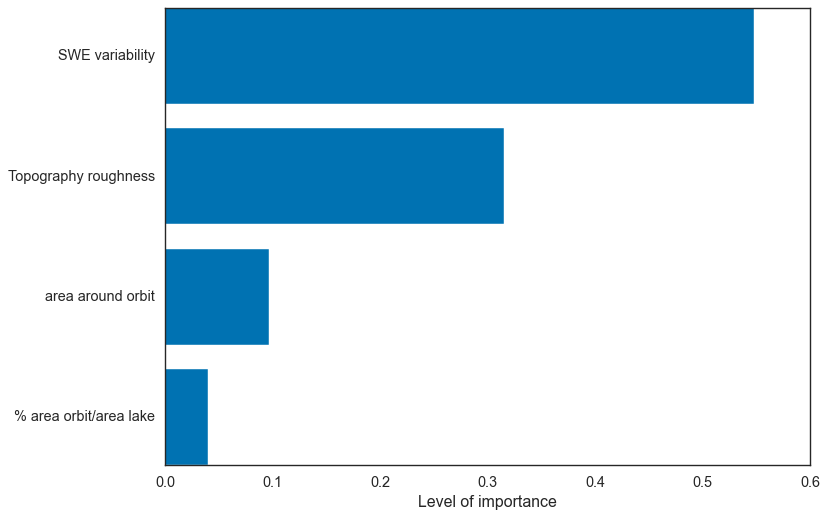

In [38]:

rf = RandomForestRegressor(n_estimators=50) #n_estimator, how many trees to use. 

new_predictors=['std_diff', 'TRI_mdn','per_area_c','area_buffe']
X=df_t_3km_vars[new_predictors]
Y=df_t_3km_vars['value']
rf.fit(X, Y)
# print(rf.feature_importances_)
# plt.barh(boston.feature_names, rf.feature_importances_)
sorted_idx = rf.feature_importances_.argsort()
# print(X.columns[sorted_idx])
plt.style.use('seaborn-white')
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Level of importance")
locs, labels = plt.yticks() 
plt.yticks(np.arange(4),['% area orbit/area lake', 'area around orbit', 'Topography roughness', 'SWE variability'])
locs


[0, 1, 2, 3]

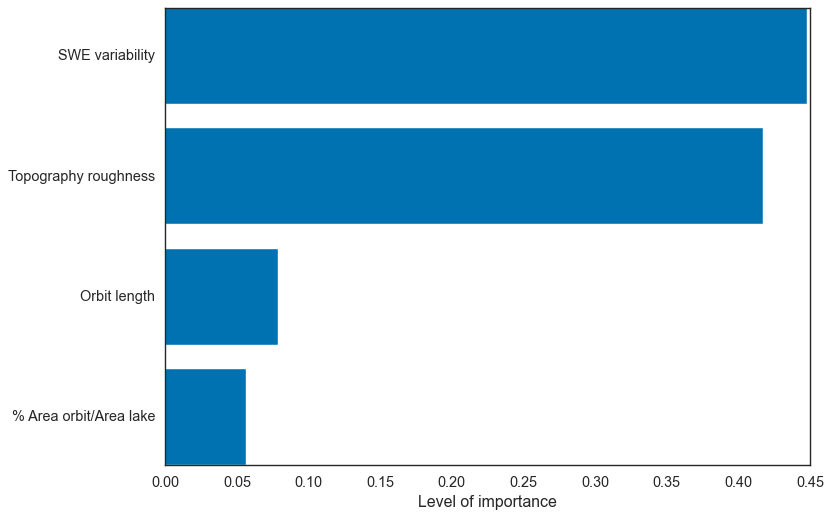

In [50]:


rf = RandomForestRegressor(n_estimators=50)

new_predictors=['std_diff', 'TRI_mdn','per_area_c','orbit_leng']
X=df_t_3km_vars[new_predictors]
Y=df_t_3km_vars['value']
rf.fit(X, Y)
# print(rf.feature_importances_)
# plt.barh(boston.feature_names, rf.feature_importances_)
sorted_idx = rf.feature_importances_.argsort()
# print(X.columns[sorted_idx])
plt.style.use('seaborn-white')
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Level of importance")
locs, labels = plt.yticks() 
plt.yticks(np.arange(4),['% Area orbit/Area lake', 'Orbit length', 'Topography roughness', 'SWE variability'])
locs


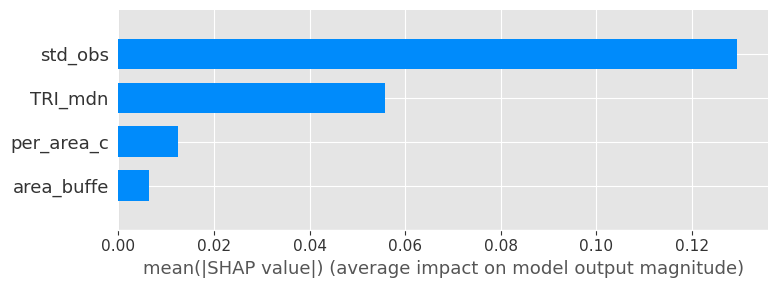

In [25]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

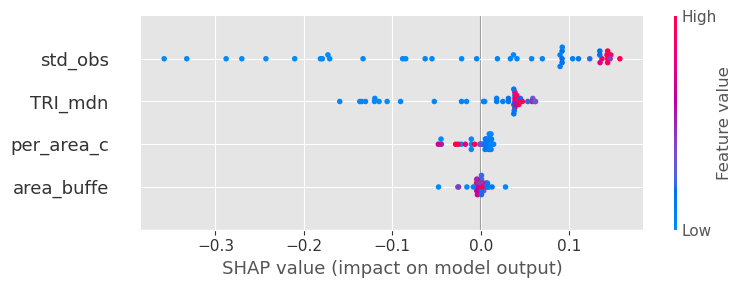

In [26]:
shap.summary_plot(shap_values, X)

In [ ]:
#best subset 
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

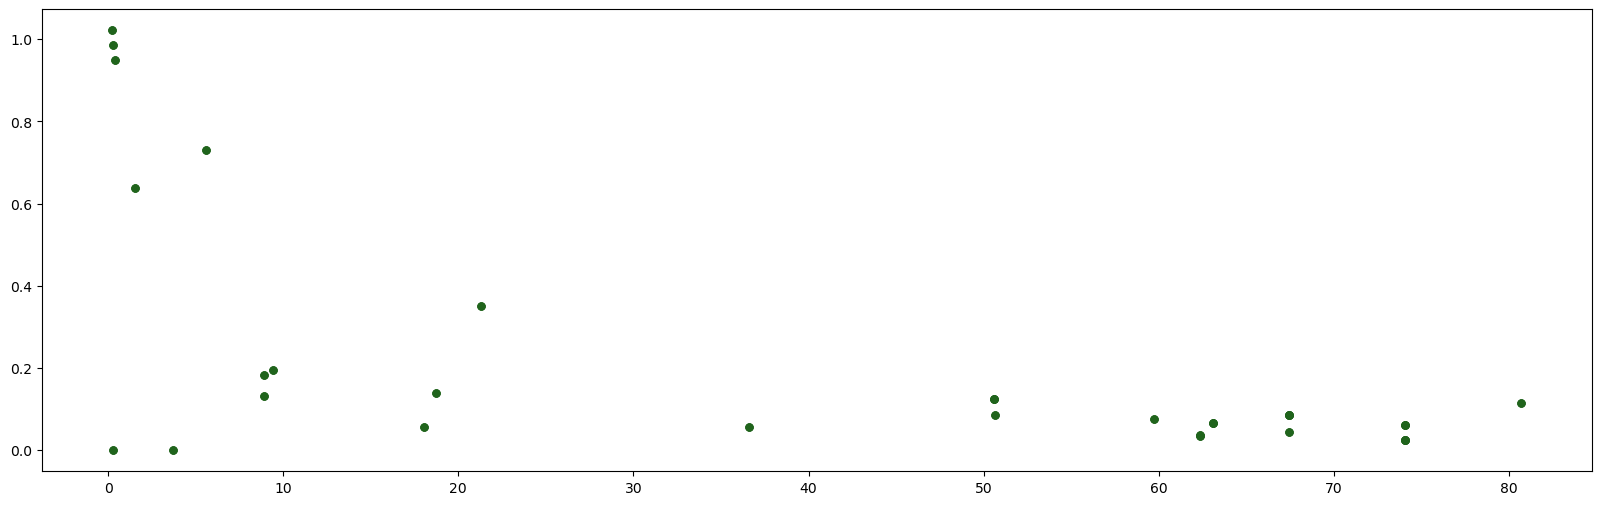

Executing shutdown due to inactivity...


2022-11-11 15:49:46,507 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-11-11 15:49:46,556 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdown_server
    raise RuntimeError("Not 

2022-11-11 15:49:46,559 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdow

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df_t_3km['Lake_area'], df_t_3km['per_area_c'],  linestyle='None',marker='o', markerfacecolor='#20641c',markeredgecolor='#20641c',markersize=5)

In [8]:
# Build step forward feature selection
sfs1 = SequentialFeatureSelector(clf,n_features_to_select='auto')

# Perform SFFS
sfs1 = sfs1.fit(X, y)

In [9]:
sfs1

SequentialFeatureSelector(estimator=LinearRegression(),
                          n_features_to_select='auto')